In [1]:
import os
import pickle
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import json
import toml
from copy import deepcopy

from multiview_consistency import computeP, remove_outliers, all_views_processed, retrieve_keypts, retrieve_common_id, select_keypoints_athlete, create_dict_all_detections, plot_view_consistency

np.set_printoptions(precision=4, suppress=True)

# Output:
# [
#   {"id": 0, "bbox": [...], "keypoints": [[x, y, score], ...]},
#   {"id": 1, "bbox": [...], "keypoints": [[x, y, score], ...]},
#   ...
# ]

## Load data

In [36]:
# Load transformation matrices
cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']
K = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_K_conf.npz')['arr_0']
D = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0425/Intrinsics_D_conf.npz')['arr_0']
extrinsics = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/Extrinsics_optimized_20250429_12h00.npz')['arr_0']
world_T_cam = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

projMat = [np.linalg.inv(mat) for mat in world_T_cam]
# projMat = world_T_cam[:, 0:3, :]

In [6]:
root_path = '/home/lea/trampo/metrics/SMPL_keypoints'

routine = '1_partie_0429'
paths = [routine+'-Camera1_M11139.pkl', routine+'-Camera2_M11140.pkl', routine+'-Camera3_M11141.pkl', routine+'-Camera4_M11458.pkl',
         routine+'-Camera5_M11459.pkl', routine+'-Camera6_M11461.pkl', routine+'-Camera7_M11462.pkl', routine+'-Camera8_M11463.pkl',]

keypts_cam = {}

for i, path in enumerate(paths):
    with open(os.path.join(root_path, path), "rb") as f:
        data = pickle.load(f)
        keypts_cam[i] = data

## Find the id with the largest vertical amplitude = athlete

In [32]:
# Parameters
min_size_threshold = 150        # Minimum bbox size
max_size_threshold = 500        # Maximum bbox size
amplitude_threshold = 500       # Overall required movement
max_jump_per_frame = 300        # Max movement between consecutive frames (L2 distance)
max_dim_change_ratio = 0.7

id_per_frame_per_cam = {}

for cam, data in keypts_cam.items():
    athlete_mids, athlete_sizes = [], []
    other_mids, other_sizes = [], []

    last_mid, last_size = None, None
    valid_track = True
    trajectory = []  # stores (frame, mid, size, id)

    sorted_frames = sorted(data.keys())
    for frame in sorted_frames:
        output = data[frame]
        if not output:
            continue

        candidates = []
        for d in output:
            bbox = d['bbox']
            id = d['id']
            size = (bbox[2], bbox[3])
            mid = (bbox[0] + bbox[2]/2, bbox[1] + bbox[3]/2)

            # Size check
            if size[0] < min_size_threshold or size[1] < min_size_threshold:
                continue
            if size[0] > max_size_threshold or size[1] > max_size_threshold:
                continue

            # Height check (above trampoline) for cameras M11139 and M11459
            if cam == 0 :
                if mid[0] < 500:
                    continue
            elif cam == 4:
                if mid[0] > (1920 - 450):
                    continue

            candidates.append((mid, size, id))

        if not candidates:
            continue

        # First frame: initialize from first valid candidate
        if last_mid is None:
            mid, size, selected_id = candidates[0]
            trajectory.append((frame, mid, size, selected_id))
            last_mid, last_size = mid, size
            continue

        # Continue track: find closest consistent bbox
        best_candidate = None
        best_jump = float('inf')
        for mid, size, id in candidates:
            """ size_ok = True
            for i in range(2):
                dim_change = abs(size[i] - last_size[i]) / last_size[i]
                if dim_change > max_dim_change_ratio:
                    size_ok = False
                    break
            if not size_ok:
                print('dim change failed')
                continue """

            jump = np.linalg.norm(np.array(mid) - np.array(last_mid))
            if jump > max_jump_per_frame:
                print('jump failed')
                continue

            if jump < best_jump:
                best_jump = jump
            best_candidate = (mid, size, id)

        if best_candidate:
            mid, size, selected_id = best_candidate
            trajectory.append((frame, mid, size, selected_id))
            last_mid, last_size = mid, size
        """ else:
            print(f"Camera {cam}: breaking at frame {frame} due to discontinuity.")
            valid_track = False
            break """


    # Check amplitude over full trajectory
    if valid_track and len(trajectory) > 1:
        mids = np.array([mid for _, mid, _, _ in trajectory])
        amp = np.max(mids, axis=0) - np.min(mids, axis=0)
        total_amp = np.linalg.norm(amp)
        if total_amp > amplitude_threshold:
            for frame, mid, size, id in trajectory:
                athlete_mids.append(mid)
                athlete_sizes.append(size)
                id_per_frame_per_cam.setdefault(cam, {}).setdefault(frame, []).append(id)
        else:
            print('total amp failed')
            print(total_amp)
            for _, mid, size, _ in trajectory:
                other_mids.append(mid)
                other_sizes.append(size)
    else:
        for _, mid, size, _ in trajectory:
            other_mids.append(mid)
            other_sizes.append(size)

    # Print stats
    print(f"Camera: {cam}")
    if athlete_mids:
        mids_np = np.array(athlete_mids)
        sizes_np = np.array(athlete_sizes)
        # print("Athlete mid stats:")
        # print("  min:", np.min(mids_np, axis=0), "  max:", np.max(mids_np, axis=0), "  mean:", np.mean(mids_np, axis=0))
        # print("Athlete bbox size stats:")
        # print("  min:", np.min(sizes_np, axis=0), "  max:", np.max(sizes_np, axis=0), "  mean:", np.mean(sizes_np, axis=0))

    if other_mids:
        mids_np = np.array(other_mids)
        sizes_np = np.array(other_sizes)
        # print("Other mid stats:")
        # print("  min:", np.min(mids_np, axis=0), "  max:", np.max(mids_np, axis=0), "  mean:", np.mean(mids_np, axis=0))
        # print("Other bbox size stats:")
        # print("  min:", np.min(sizes_np, axis=0), "  max:", np.max(sizes_np, axis=0), "  mean:", np.mean(sizes_np, axis=0))

print("\nFiltered per frame per camera:")
print(id_per_frame_per_cam)


Camera: 0
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
Camera: 1
Camera: 2
Camera: 3
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
Camera: 4
Camera: 5
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump failed
jump

## Select keypoints of the athlete + visualize keypoints movement

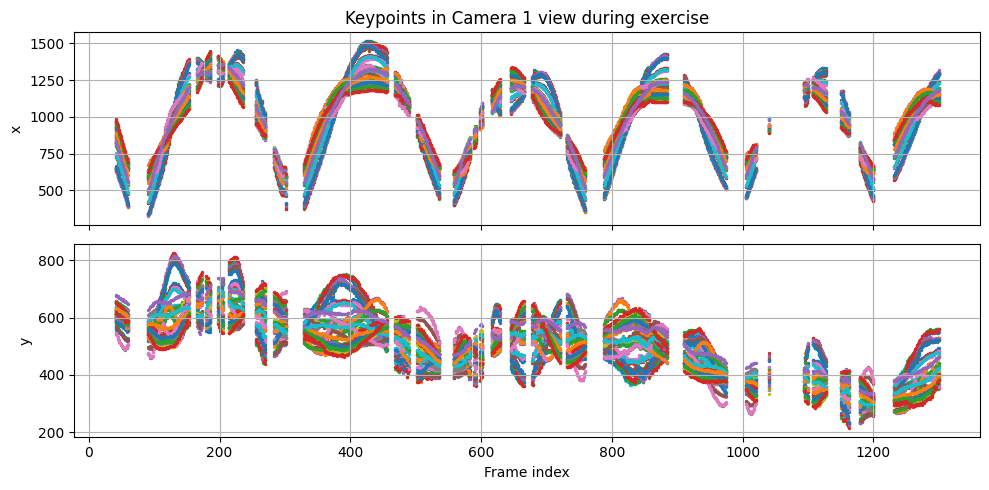

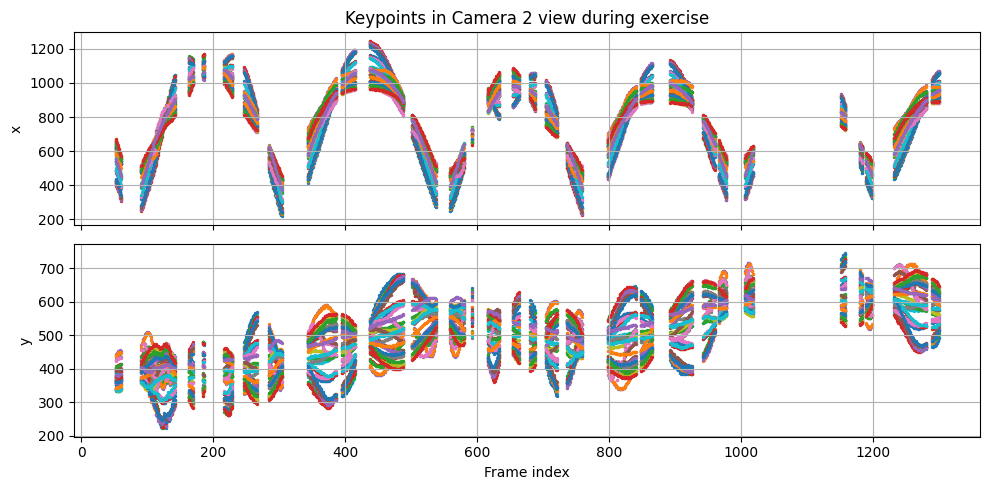

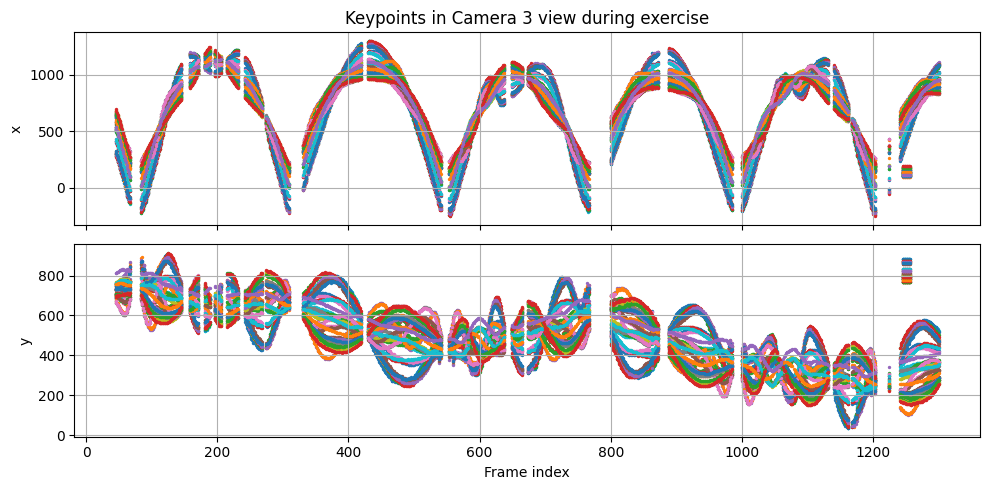

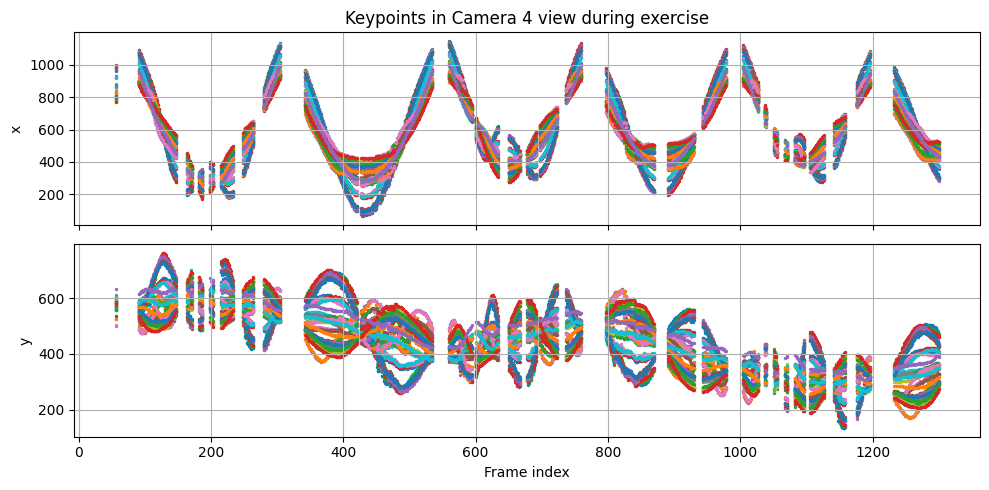

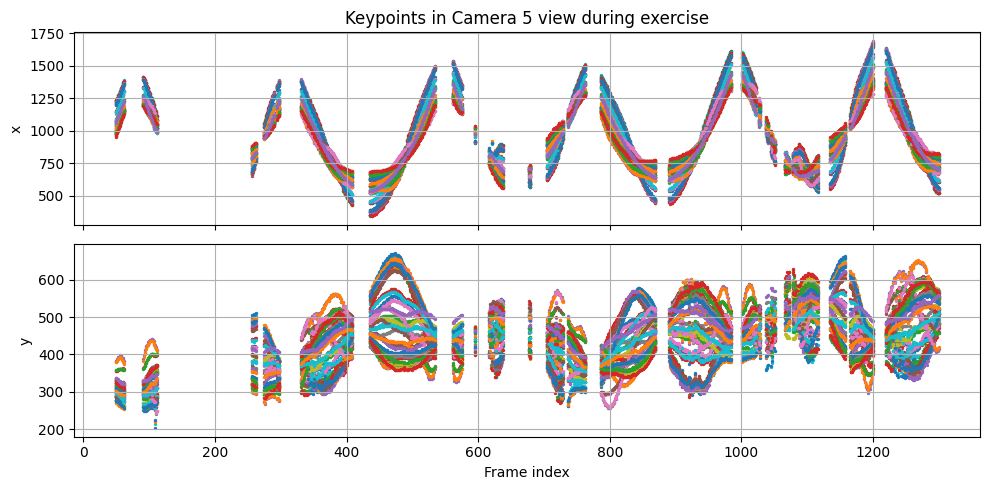

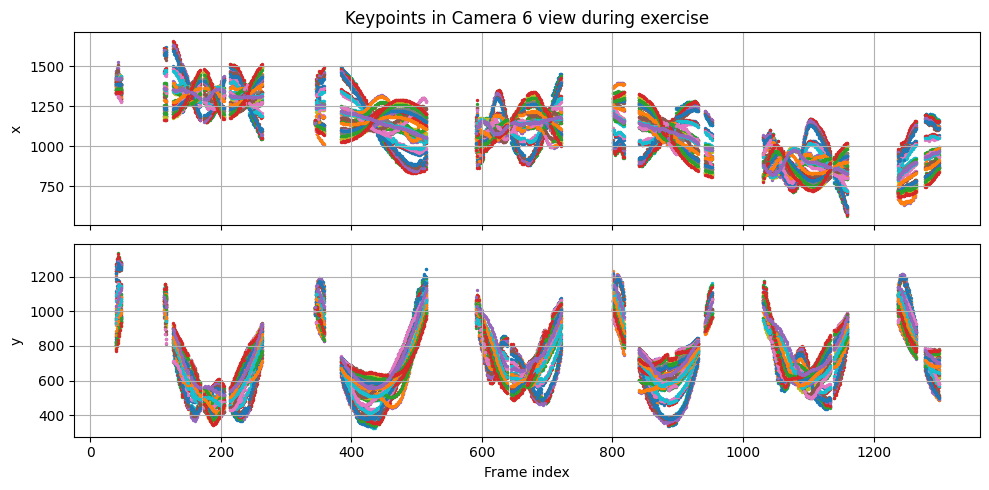

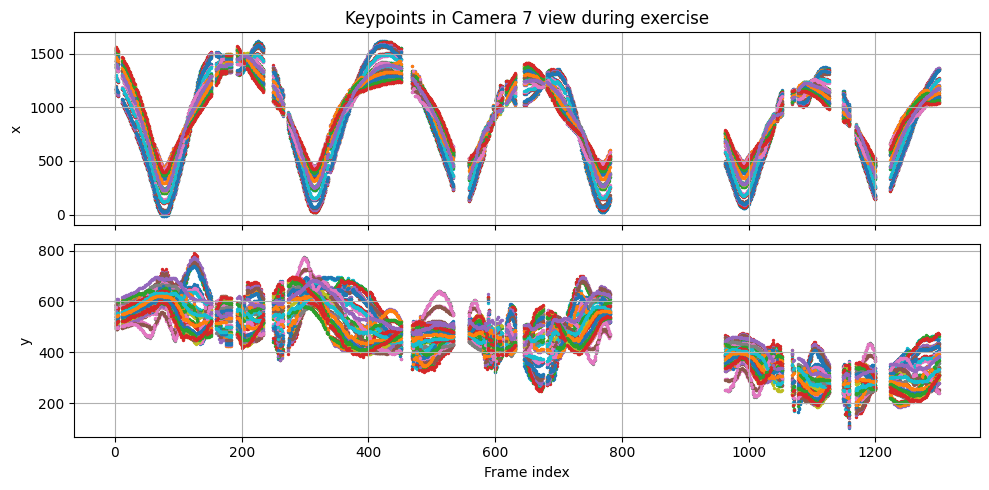

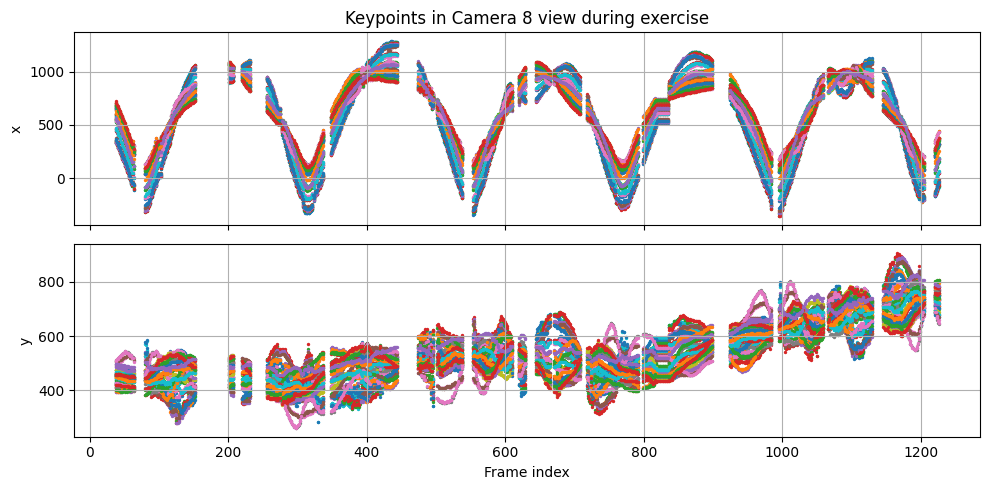

In [33]:
keypts_per_cam = {}
for cam, data in keypts_cam.items():
    pos_id = {}
    keypts = []
    for frame, output in data.items():
        for d in output:
            id = d['id']
            if frame in id_per_frame_per_cam[cam] and id in id_per_frame_per_cam[cam][frame]: # == id:
                pts = [p[0:2] for p in d['keypoints']]
                conf = [p[2] for p in d['keypoints']]
                keypts.append((frame, pts, conf))

    # Initialize lists for each coordinate per keypoint
    num_keypoints = 45
    frame_vals = [[] for _ in range(num_keypoints)]
    x_vals = [[] for _ in range(num_keypoints)]
    y_vals = [[] for _ in range(num_keypoints)]
    score_vals = [[] for _ in range(num_keypoints)]

    # Collect values for person id == 0
    for frame, pts, score in keypts:
        for i in range(num_keypoints):
            frame_vals[i].append(int(frame)) #(int(frame.split('_')[1].split('.')[0]))
            x_vals[i].append(pts[i][0])
            y_vals[i].append(pts[i][1])
            score_vals[i].append(score[i])

    keypts_per_cam[cam] = keypts

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(10,5), sharex=True)
    axes[0].set_title(f'Keypoints in Camera {cam+1} view during exercise')
    coords = ['x', 'y', 'score']
    all_vals = [frame_vals, x_vals, y_vals, score_vals]

    for i, ax in enumerate(axes):
        for kpt_id in range(num_keypoints):
            ax.scatter(all_vals[0][kpt_id], all_vals[i+1][kpt_id], s=2, label=f'kpt_{kpt_id+1}')
        ax.set_ylabel(coords[i])
        #ax.legend(loc='upper right', ncol=2, fontsize='small')
        ax.grid(True)

    axes[-1].set_xlabel('Frame index')
    plt.tight_layout()
    plt.show()


## Find frames with detection in all views

In [34]:
# 1. Find common keys across all dictionaries
lists = list(keypts_per_cam.values())

# 1. Find the set of keys in each list
key_sets = [set(row[0] for row in l) for l in lists]

# 2. Find keys that are common to all lists
common_keys = set.intersection(*key_sets)

# 3. Filter each list to keep only rows with a common key
filtered_lists = [[row for row in l if row[0] in common_keys] for l in lists]

for i, l in enumerate(filtered_lists):
    print(i, len(l))


0 94
1 94
2 94
3 94
4 94
5 94
6 94
7 94


## Create dict {frame number: {cam1: [keypts_cam1], cam2: [keypts_cam2], ...}} with all detections

In [37]:
keypts_per_cam_all = {}
for cam, data in keypts_cam.items():
    keypts = []
    for frame, output in data.items():
        for d in output:
            id = d['id']
            if frame in id_per_frame_per_cam[cam]: # == id:
                pts = [p[0:2] for p in d['keypoints']]
                conf = [p[2] for p in d['keypoints']]
                keypts.append((frame, pts, conf))

    keypts_per_cam_all[cam] = keypts

keypoints_detections = {}
N = len(os.listdir('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429/'+routine+'-Camera1_M11139'))

for frame_nb in range(N):
    if frame_nb not in keypoints_detections:
        keypoints_detections.update({frame_nb:{}})
    for c, cam in enumerate(cameras):
        for el in keypts_per_cam_all[c]:
            if f'{frame_nb:05d}' in el[0]:
                if cam not in keypoints_detections[frame_nb]:
                    keypoints_detections[frame_nb].update({cam:[el[1]]})
                else:
                    keypoints_detections[frame_nb][cam].append(el[1])

## Test multi-view consistency

In [38]:
error_cam_1 = {f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras}
error_cam_2 = deepcopy(error_cam_1)

error_cam = [{f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras} for _ in range(8)]

P_all = computeP('/home/lea/trampo/Pose2Sim/Calibration/Calib.toml')

for c1 in range(8):
    for c2 in range(c1, 8):
        if c1 != c2:
            for frame_idx in range(N):
                
                try:
                    pts1 = np.asarray(keypoints_detections[frame_idx][cameras[c1]])[0, :, :]
                    pts2 = np.asarray(keypoints_detections[frame_idx][cameras[c2]])[0, :, :]
                except KeyError:
                    continue

                #TODO: ajouter filtre pour vérifier qu'il s'agit de la même personne
                
                P1 = P_all[c1]
                P2 = P_all[c2]

                points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
                points_3d = (points_4d[:3] / points_4d[3]).T  # Nx3

                points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1)))).T  # 4xN

                pts1_reproj_h = P1 @ points_3d_h  # 3xN
                pts1_reproj = (pts1_reproj_h[:2] / pts1_reproj_h[2]).T  # Nx2

                pts2_reproj_h = P2 @ points_3d_h  # 3xN
                pts2_reproj = (pts2_reproj_h[:2] / pts2_reproj_h[2]).T  # Nx2

                for c in range(8):
                    try:
                        pts = np.asarray(keypoints_detections[frame_idx][cameras[c]])[0, :, :]
                    except KeyError:
                        continue
                    pts_reproj_h = P_all[c] @ points_3d_h
                    pts_reproj = (pts_reproj_h[:2] / pts_reproj_h[2]).T 
                    error = np.linalg.norm(pts - pts_reproj, axis=1)

                    error_cam[c][f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error))

                    """ error1 = np.linalg.norm(pts1 - pts1_reproj, axis=1)
                    error2 = np.linalg.norm(pts2 - pts2_reproj, axis=1)
                    error_cam_1[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error1))
                    error_cam_2[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error2)) """

for v, error_cam_i in enumerate(error_cam):
    error_cam_i = {k: v for k, v in error_cam_i.items() if len(v) > 0}

    """ print("Erreur de reprojection moyenne par paire de caméras:")
    for key, val in error_cam.items():
            print(f'{key}: mean = {np.mean(val):.2f}, std = {np.std(val):.2f}') """

    labels = []
    data_filtered = []
    means = []
    stds = []
    used_images = 0

    #print("Outliers par paire de caméras :")
    for key, val in error_cam_i.items():
        val_filtered, outliers = remove_outliers(val)
        if len(val_filtered) == 0:
            continue  # skip if all values are outliers
        
        used_images += len(val_filtered)
        labels.append(key)
        data_filtered.append(val_filtered)
        mean_val = np.mean(val_filtered)
        std_val = np.std(val_filtered)
        means.append(mean_val)
        stds.append(std_val)
        #if len(outliers) > 0:
            #print(f"{key}: {len(outliers)} outlier(s), mean = {np.mean(outliers)}")

    # Création du boxplot sans outliers
    plt.figure(figsize=(14,7))
    box = plt.boxplot(data_filtered, labels=labels, patch_artist=True,
                        showfliers=False, medianprops={'color': 'red'})

    # Couleurs personnalisées (facultatif)
    colors = plt.cm.viridis(np.linspace(0, 1, len(data_filtered)))
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)

    # Ajouter les moyennes et écarts-types
    for i, (mean, std) in enumerate(zip(means, stds)):
        plt.text(i + 1, mean, f"μ = {mean:.0f}\nσ = {std:.0f}", 
                ha='center', fontsize=8, color='green',
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.7))

    # Mise en page
    plt.title(f"Erreur de reprojection sur la vue {v+1} ({cameras[v]}) par paire de caméras (sans outliers, {used_images} projections)")
    plt.xlabel("Paire de caméras")
    plt.ylabel("Erreur de reprojection (pixels)")
    plt.ylim(0,500)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'reproj_figures/Reproj_{routine}_vue{v+1}')
    plt.show()


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'triangulatePoints'
> Overload resolution failed:
>  - projMatr1 is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'projMatr1'


### Proportion of outliers

For 39-40 : 7.63% of outliers
For 39-41 : 6.48% of outliers
For 39-58 : 7.14% of outliers
For 39-59 : 4.89% of outliers
For 39-61 : 5.39% of outliers
For 39-62 : 9.91% of outliers
For 39-63 : 6.60% of outliers
For 40-41 : 5.71% of outliers
For 40-58 : 1.15% of outliers
For 40-59 : 14.88% of outliers
For 40-61 : 5.07% of outliers
For 40-62 : 6.89% of outliers
For 40-63 : 6.83% of outliers
For 41-58 : 8.32% of outliers
For 41-59 : 9.07% of outliers
For 41-61 : 10.74% of outliers
For 41-62 : 11.22% of outliers
For 41-63 : 7.48% of outliers
For 58-59 : 2.19% of outliers
For 58-61 : 5.40% of outliers
For 58-62 : 5.79% of outliers
For 58-63 : 6.17% of outliers
For 59-61 : 6.39% of outliers
For 59-62 : 9.70% of outliers
For 59-63 : 6.38% of outliers
For 61-62 : 5.10% of outliers
For 61-63 : 0.65% of outliers
For 62-63 : 3.27% of outliers
Average proportion of outliers: 6.66%


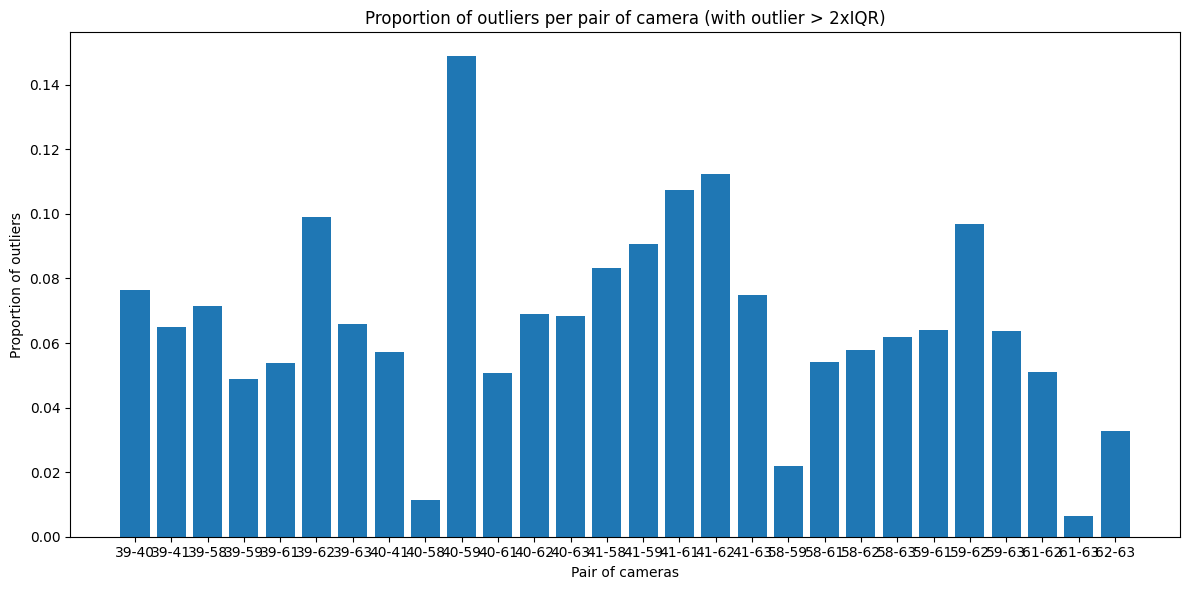

In [ ]:
from multiview_consistency import remove_outliers

with open('/home/lea/vitpose/error_vitL.json', 'r') as f:
    error_cam = json.load(f)

error_cam = {k: error_cam[k] for k in sorted(error_cam)}

out_rate = []
rate_dict = {}

for key, val in error_cam.items():
    filtered, outliers = remove_outliers(val, 2, 1000)
    #print(key)
    Nout = len(outliers)
    Nfilt = len(filtered)
    #print('Nb filtered:', Nfilt)
    #print('Nb outliers:', Nout)
    proportion = Nout/(Nfilt+Nout)
    rate_dict[key] = proportion
    print(f'For {key} : {proportion:.2%} of outliers')
    out_rate.append(proportion)

print(f'Average proportion of outliers: {np.mean(out_rate):.2%}')

plt.figure(figsize=(12,6))
plt.bar(rate_dict.keys(), rate_dict.values())
plt.title('Proportion of outliers per pair of camera (with outlier > 2xIQR)')
plt.xlabel('Pair of cameras')
plt.ylabel('Proportion of outliers')
plt.tight_layout()
plt.show()

## Transform the keypoints from all camera views to camera 1

In [ ]:
def draw_camera(ax, T_world_cam, color='r', scale=500):
    origin = T_world_cam[:3, 3]
    x_axis = T_world_cam[:3, 0] * scale + origin
    y_axis = T_world_cam[:3, 1] * scale + origin
    z_axis = T_world_cam[:3, 2] * scale + origin
    ax.plot([origin[0], x_axis[0]], [origin[1], x_axis[1]], [origin[2], x_axis[2]], color='r')
    ax.plot([origin[0], y_axis[0]], [origin[1], y_axis[1]], [origin[2], y_axis[2]], color='g')
    ax.plot([origin[0], z_axis[0]], [origin[1], z_axis[1]], [origin[2], z_axis[2]], color='b')
    return

def draw_keypoints(points_3d, colors, ax, c, size, fontsize):
    for i, (x, y, z) in enumerate(points_3d):
        ax.scatter(x, y, z, s=size, color=colors[c])
        ax.text(x, y, z, str(i), fontsize=fontsize, color='black')
    return

def draw_skeleton(points_3d, color, ax, label=None, skel=17):
    if skel == 17:
        skeleton = [
            (5, 6),  # épaule gauche - coude gauche
            (5, 7),  # coude gauche - poignet gauche
            (7, 9),
            (6, 8),  # épaule droite - coude droit
            (8, 10), # coude droit - poignet droit
            (6, 12), # épaule gauche - hanche gauche
            (12, 14),# hanche gauche - hanche droite
            (14, 16),# hanche gauche - genou gauche
            (5, 11),
            (11, 13),# genou gauche - cheville gauche
            (13, 15),# hanche droite - genou droit
            (11, 12)]
    elif skel == 45:
        skeleton = [
            (16, 15),
            (0, 15),
            (0, 16),
            (0, 42),
            (0, 40),
            (40, 41),
            (41, 39),
            (40, 33),
            (33, 32),
            (32, 31),
            (40, 34),
            (34, 35),
            (35, 36),
            (39, 9),
            (9, 10),
            (10, 11),
            (39, 12),
            (12, 13),
            (13, 14)]

    for i, j in skeleton:
        xline = [points_3d[i][0], points_3d[j][0]]
        yline = [points_3d[i][1], points_3d[j][1]]
        zline = [points_3d[i][2], points_3d[j][2]]
        ax.plot(xline, yline, zline, color=color)
    ax.plot(xline, yline, zline, color=color, label=label)
    return
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



cam1: 0 ('frame_00348.png', [[839.2767333984375, 575.6443481445312], [829.93701171875, 578.0403442382812], [842.7552490234375, 580.19775390625], [817.5233154296875, 580.2316284179688], [846.552001953125, 583.0200805664062], [804.24951171875, 559.4046630859375], [858.914794921875, 579.6387939453125], [784.50537109375, 506.26177978515625], [876.44580078125, 599.2855834960938], [779.9766845703125, 450.5006103515625], [841.068115234375, 595.2633056640625], [809.3331298828125, 501.999755859375], [836.59326171875, 495.7537841796875], [773.410888671875, 436.91693115234375], [804.6982421875, 440.9691162109375], [719.893798828125, 426.01104736328125], [746.1485595703125, 444.9122314453125]], [0.6477229595184326, 0.5921543836593628, 0.7360044121742249, 0.6813114881515503, 0.6056679487228394, 0.8285542130470276, 0.6268163919448853, 0.8190723061561584, 0.9295191168785095, 0.6462219953536987, 0.9198957681655884, 0.6396605968475342, 0.6943941116333008, 0.9416941404342651, 0.7911646962165833, 0.8242

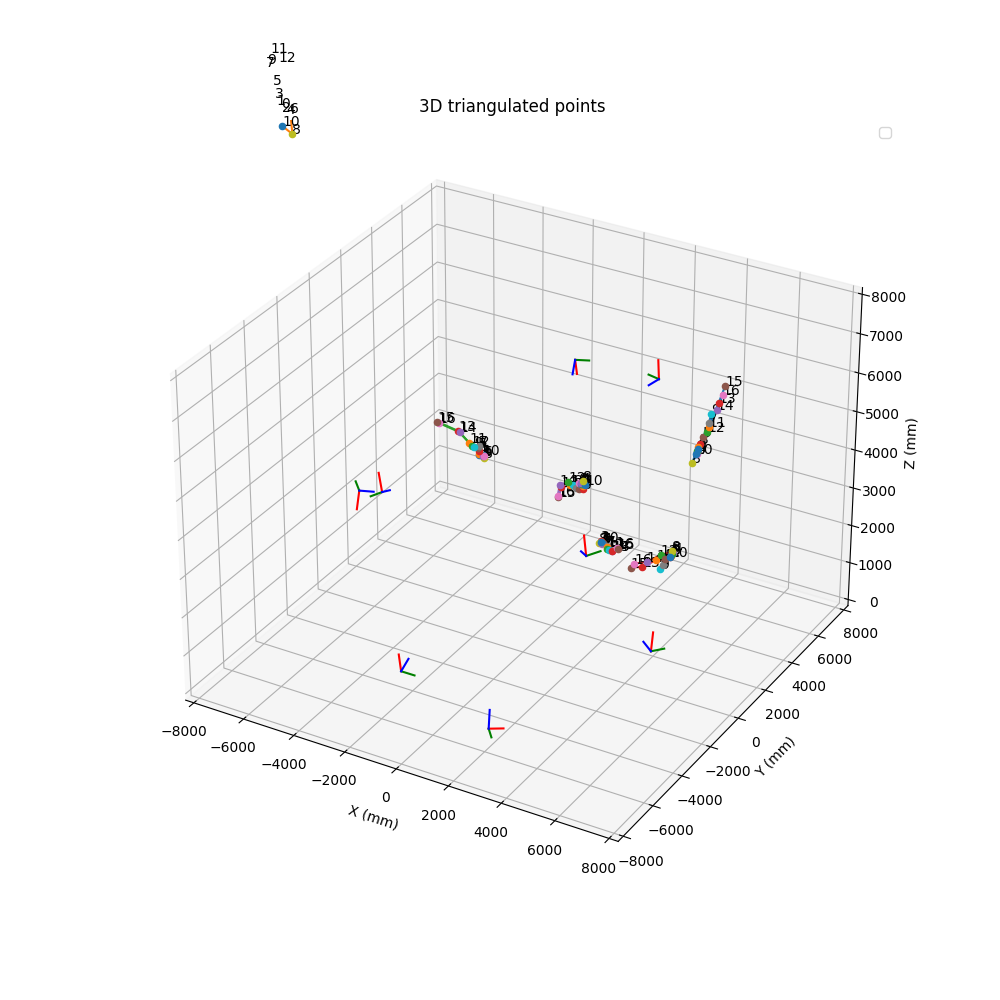

In [ ]:
%matplotlib widget

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color'] *2

projMat = [np.linalg.inv(mat)[0:3, :] for mat in world_T_cam]
cams = list(keypts_per_cam.keys())
H, W = 1920, 1080
im_size = [[H,W], [H,W], [H,W], [H,W], [H,W], [W,H], [H,W], [H,W]] #camera 6 in landscape during acquisitions

points_array = []

j = 0
for cam1 in cams[:-1]:
    h1, w1 = im_size[cam1]

    cam2 = cams[cams.index(cam1)+1]
    h2, w2 = im_size[cam2]

    print("\ncam1:", cam1, filtered_lists[cam1][j])  # index
    print("cam2:", cam2, filtered_lists[cam2][j])

    pts1_im = np.asarray(filtered_lists[cam1][j][1], dtype=np.float32)
    pts2_im = np.asarray(filtered_lists[cam2][j][1], dtype=np.float32)

    # Rotate all points
    pts1_im_r = np.empty(pts1_im.shape)
    pts2_im_r = np.empty(pts2_im.shape)

    pts1_im_r[:,0] = pts1_im[:,1]
    pts1_im_r[:,1] = h1- 1 - pts1_im[:,0]

    pts2_im_r[:,0] = pts2_im[:,1]
    pts2_im_r[:,1] = h2 - 1 - pts2_im[:,0]

    #print('Original points:')
    #print(pts1_im[:9], '\n', pts2_im[:9])

    undist_pts1 = cv2.undistortPoints(pts1_im_r, K[cam1], D[cam1]).reshape(-1, 2)
    undist_pts2 = cv2.undistortPoints(pts2_im_r, K[cam2], D[cam2]).reshape(-1, 2)

    # Perform triangulation
    pts_4d = cv2.triangulatePoints(projMat[cam1], projMat[cam2], undist_pts1.T, undist_pts2.T)

    # From camera1 to world
    pts_3d_cam = pts_4d[:, :] / pts_4d[3, :]
    pts_3d_world = world_T_cam[cam1] @ pts_3d_cam
    points_3d = pts_3d_world[:3, :].T  # Final shape (N, 3)

    """ pts_3d_cam = pts_4d[:3, :] / pts_4d[3, :]
    points_3d = pts_3d_cam[:3, :].T  # Final shape (N, 3) """ 
    points_array.append(points_3d)

    # Reprojection to camera frame
    pt_world_h = np.hstack((points_3d[0], 1)).reshape(4, 1)
    pt_cam1 = projMat[cam1] @ pt_world_h  # Camera frame
    pt_cam1 = pt_cam1[:3] / pt_cam1[2]
    pix1 = (K[cam1] @ pt_cam1)[0:2]

    #print('Reprojected points:')
    #print(pix1[:2].T) #, reproj1[:2].T)

    #break

# Create 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

points_array = np.array(points_array).reshape(-1, 17, 3)

# Tracer les points
for c, keypoints in enumerate(points_array):
    for i, (x, y, z) in enumerate(keypoints):
    #ax.scatter(keypoints[:,0], keypoints[:,1], keypoints[:,2], label=c)
        ax.scatter(x, y, z, color=colors[i])
        ax.text(x, y, z, str(i), color='black')  # Optionnel : afficher l’indice du point

    # Relier les points avec des lignes
    draw_skeleton(keypoints, colors[c])

for i, T in enumerate(world_T_cam):
    draw_camera(ax, T, color=colors[i % len(colors)])

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_xlim(-8000, 8000)
ax.set_ylim(-8000, 8000)
ax.set_zlim(0, 8000)
ax.set_title('3D triangulated points')
ax.legend()
#ax.axis('equal')
plt.show()

### Test of projection + triangulation of known 3D point in world space

In [ ]:
pt_world = np.array([1000, 1000, 2000, 1])  # A known 3D point
print(pt_world)

pixel_coords = []
for i in range(8):
    pt_cam = projMat[i] @ pt_world  # Camera frame
    pt_cam = pt_cam[:3] / pt_cam[2]
    pix = (K[i] @ pt_cam)[0:2]
    print(i, pix)
    pixel_coords.append(pix)

for cam1 in range(len(pixel_coords)-1):
    cam2 = cam1+1

    pts1_im = pixel_coords[cam1]
    pts2_im = pixel_coords[cam2]

    undist_pts1 = cv2.undistortPoints(pts1_im, K[cam1], D[cam1]).reshape(-1, 2)
    undist_pts2 = cv2.undistortPoints(pts2_im, K[cam2], D[cam2]).reshape(-1, 2)

    # Perform triangulation
    pts_4d = cv2.triangulatePoints(projMat[cam1], projMat[cam2], undist_pts1.T, undist_pts2.T)

    # From camera1 to world
    pts_3d_cam = pts_4d[:3, :] / pts_4d[3, :]
    points_3d = pts_3d_cam[:3, :].T  # Final shape (N, 3)
    print(points_3d)

[1000 1000 2000    1]
0 [574.0658 755.3181]
1 [333.1059 360.6451]
2 [225.8102 757.6815]
3 [995.7416 667.7306]
4 [1178.3472  422.5615]
5 [1556.2424 1620.0519]
6 [492.3894 875.3408]
7 [146.7122 151.7579]
[[1016.4045 1033.6271 1954.3861]]
[[1028.5119 1080.401  1969.3343]]
[[1013.3708  967.7052 1977.0469]]
[[1001.8654  996.4028 1995.4259]]
[[1022.4041 1026.6681 1967.8765]]
[[1009.615  1009.5069 1971.4247]]
[[ 967.9787 1027.6682 1976.8117]]


### Test of projection + triangulation of multiple 3D points in world space

In [ ]:
pt_world = np.array([[1000, 1000, 2000, 1],
                     [0, 0, 6000, 1],
                     [-4000, 200, 4000, 1],
                     [500, 3000, 5000, 1],
                     [3000, 2000, 6000, 1]])  # A known 3D point
pt_world = pt_world.T
print(pt_world.shape)

""" points_3d = np.array(points_3d_mm).T  # shape (3, N)
pt_world = np.vstack((points_3d, np.ones((1, points_3d.shape[1])))) """

pixel_coords = []
for i in range(8):
    pt_cam = projMat[i] @ pt_world  # Camera frame
    pt_cam = pt_cam[:3] / pt_cam[2]
    pix = (K[i] @ pt_cam)[0:2]
    #print(i, pix)
    pixel_coords.append(pix)

#print(pixel_coords)
#print(np.array(pixel_coords).shape)

for cam1 in range(len(pixel_coords)-1):
    cam2 = cam1+1

    pts1_im = pixel_coords[cam1]
    pts2_im = pixel_coords[cam2]

    undist_pts1 = cv2.undistortPoints(pts1_im, K[cam1], D[cam1]).reshape(-1, 2)
    undist_pts2 = cv2.undistortPoints(pts2_im, K[cam2], D[cam2]).reshape(-1, 2)

    # Perform triangulation
    pts_4d = cv2.triangulatePoints(projMat[cam1], projMat[cam2], undist_pts1.T, undist_pts2.T)

    # From camera1 to world
    pts_3d_cam = pts_4d[:3, :] / pts_4d[3, :]
    points_3d = pts_3d_cam[:3, :].T  # Final shape (N, 3)
    print(points_3d)

(4, 5)
[[ 1016.4045  1033.6271  1954.3861]
 [    3.0256   -12.6953  6021.1792]
 [-4092.199    209.2402  3992.0303]
 [  514.4948  3043.5429  5013.1263]
 [ 3078.8162  1991.4738  6034.9531]]
[[ 1028.5119  1080.401   1969.3343]
 [    1.3837     4.3357  6004.4281]
 [-4054.9941   248.6534  3994.9545]
 [  500.7092  3002.2749  5000.0861]
 [ 3053.5276  2072.3766  6024.8999]]
[[ 1013.3708   967.7052  1977.0469]
 [  -27.7025   149.0239  6078.764 ]
 [-4073.6448   276.9691  4034.1548]
 [  497.8428  3048.4325  5025.865 ]
 [ 3030.1794  2025.5163  6032.7637]]
[[ 1001.8654   996.4028  1995.4259]
 [   -3.5861    -0.7935  6081.0376]
 [-4061.1599   258.3868  4030.6831]
 [  506.3748  3025.633   5027.7176]
 [ 3037.618   2004.2136  6049.4667]]
[[ 1022.4041  1026.6681  1967.8765]
 [    0.4231     6.4526  6037.1374]
 [-4053.1339   217.3745  3989.4045]
 [  513.3691  3048.712   5009.6219]
 [ 3057.1823  2041.8621  6039.7009]]
[[ 1009.615   1009.5069  1971.4247]
 [   -2.4984     1.5976  6009.9762]
 [-4082.9324   2

### Test of triangulation + reprojection of known 3D points

[[931.1045 524.9898]
 [927.9189 527.6094]
 [931.4724 528.4992]
 [937.0171 529.4837]
 [938.2139 528.1194]]
[[524.9898 987.8955]
 [527.6094 991.0811]
 [528.4992 987.5276]
 [529.4837 981.9829]
 [528.1194 980.7861]]


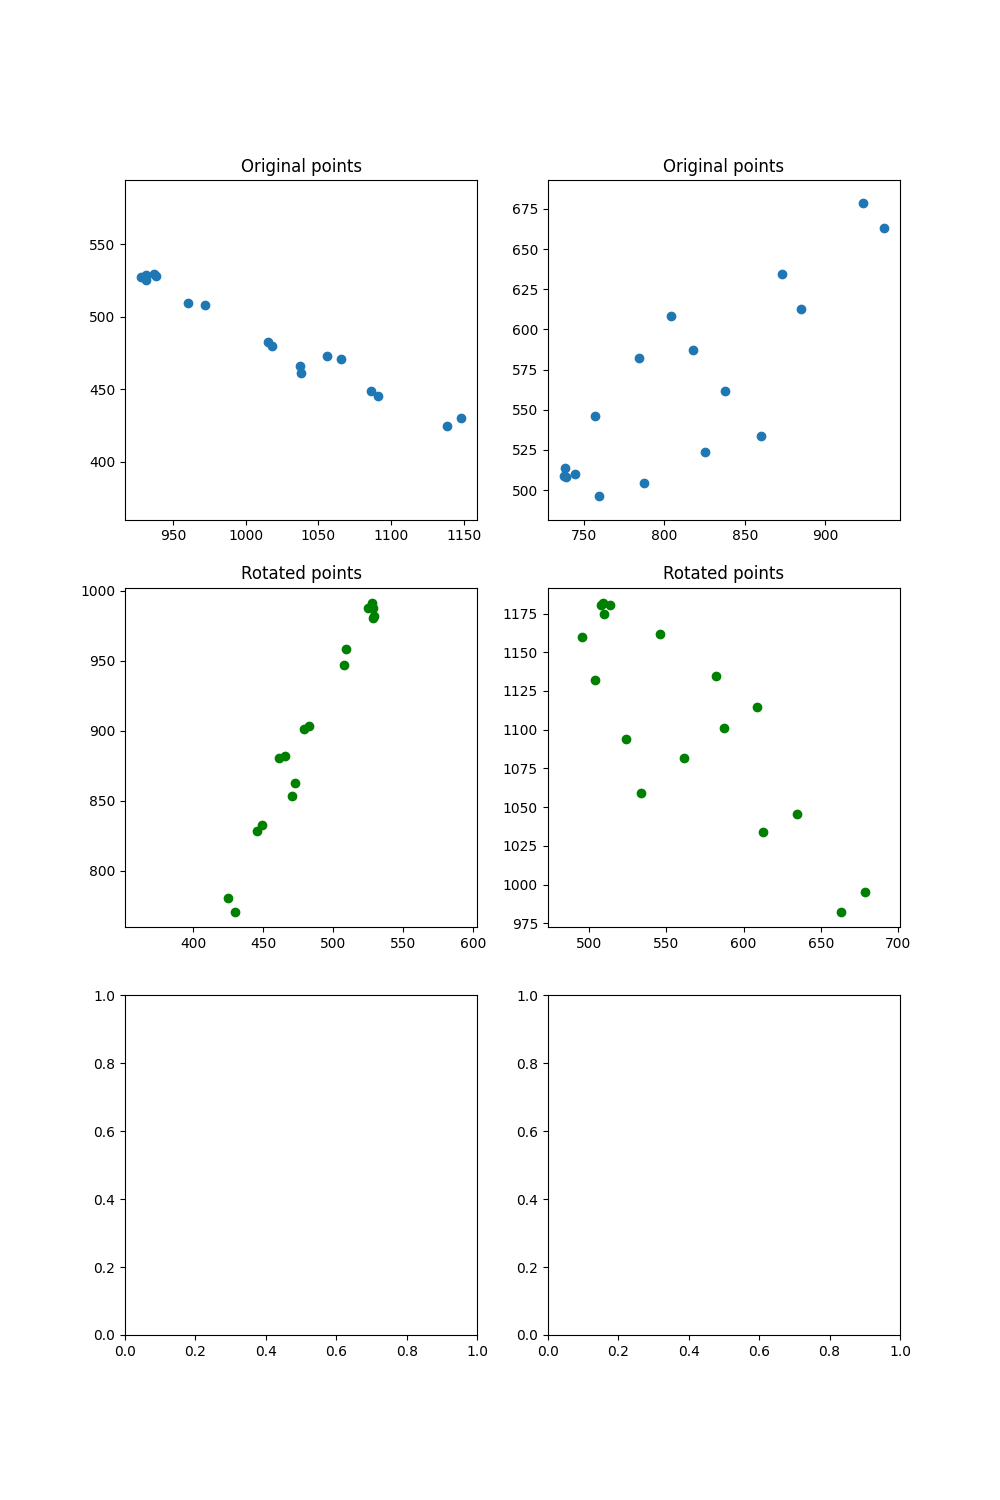

[[ 596.5426 4955.2596 2824.0028]
 [ 599.7808 4955.7604 2825.6468]
 [ 577.0442 4932.064  2818.616 ]
 [ 547.9608 4895.5225 2812.6315]
 [ 543.3524 4838.4577 2784.3571]
 [ 481.0644 4843.5252 2788.4783]
 [ 516.1876 4745.5785 2733.4927]
 [ 413.6006 4761.2361 2762.743 ]
 [ 378.137  4529.094  2652.7854]
 [ 287.4442 4627.7357 2768.4865]
 [ 207.8268 4261.3899 2592.9482]
 [ 428.6937 4692.0586 2741.7422]
 [ 394.9944 4557.7664 2693.6339]
 [ 359.8132 4515.6144 2804.1308]
 [ 343.1616 4417.8601 2761.2724]
 [ 308.9664 4328.5752 2916.7415]
 [ 381.3898 4328.8344 2887.4862]]
[[ 822.9452 1085.0234]
 [ 823.0579 1085.5362]
 [ 822.6522 1080.7067]
 [ 822.4715 1074.1862]
 [ 818.1356 1069.0552]]


In [ ]:
H, W = 1920, 1080

pts1_im = np.array(filtered_lists[0][2][1])
pts2_im = np.array(filtered_lists[1][2][1])
print(pts1_im[:5])

# Rotate all points
pts1_im_r = np.empty(pts1_im.shape)
pts2_im_r = np.empty(pts2_im.shape)

pts1_im_r[:,0] = pts1_im[:,1]
pts1_im_r[:,1] = H - 1 - pts1_im[:,0]

pts2_im_r[:,0] = pts2_im[:,1]
pts2_im_r[:,1] = H - 1 - pts2_im[:,0]

print(pts1_im_r[:5])
#print(pts2_im_r[:5])

fig, ([ax1, ax2], [ax3, ax4], [ax5, ax6]) = plt.subplots(3,2, figsize=(10,15))
ax1.scatter(pts1_im[:,0], pts1_im[:,1])
ax1.axis('equal')
ax1.set_title('Original points')
ax2.scatter(pts2_im[:,0], pts2_im[:,1])
ax2.axis('equal')
ax2.set_title('Original points')
ax3.scatter(pts1_im_r[:,0], pts1_im_r[:,1], c='green')
ax3.axis('equal')
ax3.set_title('Rotated points')
ax4.scatter(pts2_im_r[:,0], pts2_im_r[:,1], c='green')
ax4.axis('equal')
ax4.set_title('Rotated points')
plt.show()

points_array = []
for cam1 in [0]:
    cam2 = cam1+1

    undist_pts1 = cv2.undistortPoints(pts1_im_r, K[cam1], D[cam1]).reshape(-1, 2)
    undist_pts2 = cv2.undistortPoints(pts2_im_r, K[cam2], D[cam2]).reshape(-1, 2)

    # Perform triangulation
    pts_4d = cv2.triangulatePoints(projMat[cam1], projMat[cam2], undist_pts1.T, undist_pts2.T)

    # From camera1 to world
    pts_3d_cam = pts_4d[:3, :] / pts_4d[3, :]
    points_3d = pts_3d_cam[:3, :].T  # Final shape (N, 3)

    """ pts_3d_cam = pts_4d[:, :] / pts_4d[3, :]
    pts_3d_world = world_T_cam[cam1] @ pts_3d_cam
    points_3d = pts_3d_world[:3, :].T  # Final shape (N, 3) """
    
    points_array.append(points_3d)

points_array = np.array(points_array).squeeze()
print(points_array)

reproj = []
for i in [0,1]:
    pt_cam = projMat[i] @ np.hstack((points_array, np.ones((17,1)))).T  # Camera frame
    pt_cam = pt_cam[:3] / pt_cam[2]
    pix = (K[i] @ pt_cam)[0:2]
    reproj.append(pix)

print(reproj[0].T[:5])
#print(reproj[1].T[:5])
reproj = np.array(reproj).reshape(2,17,2)

ax5.scatter(reproj[0][:,0], reproj[0][:,1])
ax5.axis('equal')
ax5.set_title('Reprojected points')
ax6.scatter(reproj[1][:,0], reproj[1][:,1])
ax6.axis('equal')
ax6.set_title('Reprojected points')

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlim(0, 1920)
    ax.set_ylim(0, 1920)

#plt.close()

## Project keypoints triangulated with Pose2Sim

In [ ]:
def reprojection(P_all, Q):
    '''
    Reprojects 3D point on all cameras.
    
    INPUTS:
    - P_all: list of arrays. Projection matrix for all cameras
    - Q: array of triangulated point (x,y,z,1.)

    OUTPUTS:
    - x_calc, y_calc: list of coordinates of point reprojected on all cameras
    '''
    
    x_calc, y_calc = [], []
    for c in range(len(P_all)):  
        P_cam = P_all[c]
        x_calc.append(P_cam[0] @ Q / (P_cam[2] @ Q))
        y_calc.append(P_cam[1] @ Q / (P_cam[2] @ Q))
        
    return np.array([x_calc, y_calc]).T

def euclidean_distance(q1, q2):
    '''
    Euclidean distance between 2 points (N-dim).
    
    INPUTS:
    - q1: list of N_dimensional coordinates of point
         or list of N points of N_dimensional coordinates
    - q2: idem

    OUTPUTS:
    - euc_dist: float. Euclidian distance between q1 and q2
    '''
    
    q1 = np.array(q1)
    q2 = np.array(q2)
    dist = q2 - q1
    if np.isnan(dist).all():
        dist = np.empty_like(dist)
        dist[...] = np.inf
    
    if len(dist.shape)==1:
        euc_dist = np.sqrt(np.nansum( [d**2 for d in dist]))
    else:
        euc_dist = np.sqrt(np.nansum( [d**2 for d in dist], axis=1))
    
    return euc_dist

def load_trc(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Read meta header
    header_lines = 5
    column_line = lines[3]
    columns = column_line.strip().split('\t')[2:]  # Skip 'Frame#' and 'Time'
    
    # Construct column names with joint and axis labels
    joint_names = []
    for i in range(0, len(columns), 3):
        joint = columns[i].strip()
        joint_names.append(joint)

    coords = ['X', 'Y', 'Z']
    full_columns = []
    for joint in joint_names:
        for coord in coords:
            full_columns.append(f'{joint}_{coord}')
    
    # Read data
    df = pd.read_csv(filename, sep='\t', skiprows=header_lines)
    df = df.iloc[:, 2:]  # Skip Frame# and Time columns
    df.columns = full_columns
    return df, joint_names

def extract_keypoints(filename):
    # Load JSON file
    with open(filename, "r") as f:
        data = json.load(f)

    if len(data["people"][0]) > 0:
        keypoints = data["people"][0]["pose_keypoints_2d"]
        keypoints = np.array(keypoints).reshape((-1, 3))

        # Access x, y, and confidence separately if needed
        x_coords = keypoints[:, 0]
        y_coords = keypoints[:, 1]
        confidences = keypoints[:, 2]

        return (x_coords, y_coords), confidences
    
    return (None, None), None

def project_points_to_camera(points_3d, K, T, im_size=(1920,1080)):
    """
    Projects 3D points to 2D image coordinates using camera intrinsics and extrinsics.

    Args:
        points_3d: (N, 3) array of 3D points.
        K: (3, 3) intrinsic matrix.
        T: (4, 4) extrinsic matrix (camera pose).
        im_size: tuple (width, height), optional. If provided, returns a mask for points inside the image.

    Returns:
        points_2d: (N, 2) projected 2D points.
        valid_mask: (N,) boolean array (only if im_size is given).
    """
    points_3d = np.array(points_3d) # shape (3, N)
    points_3d = np.hstack((points_3d, np.ones((points_3d.shape[0], 1))))
    points_cam = T @ points_3d.T # shape (3, N)
    
    points_cam = points_cam[0:3,:] / points_cam[3,:]
    points_2d_h = K @ points_cam  # shape (3, N)

    points_2d = points_2d_h[:2, :] / points_2d_h[2, :]  # normalize
    points_2d = points_2d.T

    if im_size is not None:
        width, height = im_size
        x, y = points_2d[:, 0], points_2d[:, 1]
        valid_mask = (
            (points_cam[2, :] > 0) &  # In front of camera
            (x >= 0) & (x < width) &
            (y >= 0) & (y < height)
        )
        return points_2d, valid_mask

    return points_2d, np.ones(points_2d.shape[0])  # shape (N, 2)

def compute_rmse(original_pts, projected_pts):
    original_pts = np.asarray(original_pts).reshape(-1, 2)
    projected_pts = np.asarray(projected_pts).reshape(-1, 2)

    error = np.linalg.norm(original_pts - projected_pts, axis=1)  # Euclidean distance per point
    rmse = np.sqrt(np.mean(error**2))  # Compute RMSE
    return rmse


P_all = computeP('/home/lea/vitpose/Pose2Sim/Calibration/Calib.toml')

RMSE for cam M11139, person 0: 536.60 pix


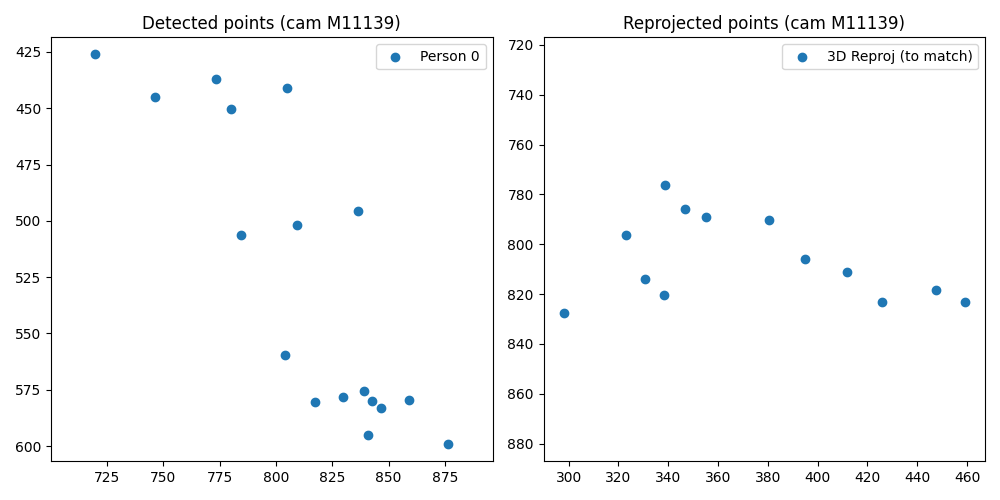

RMSE for cam M11140, person 0: 1489.53 pix


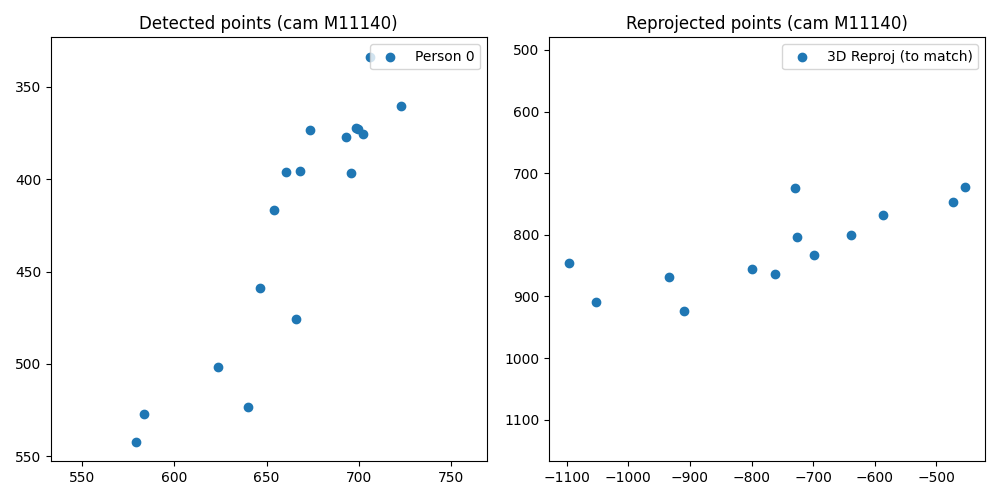

RMSE for cam M11141, person 0: 859.49 pix


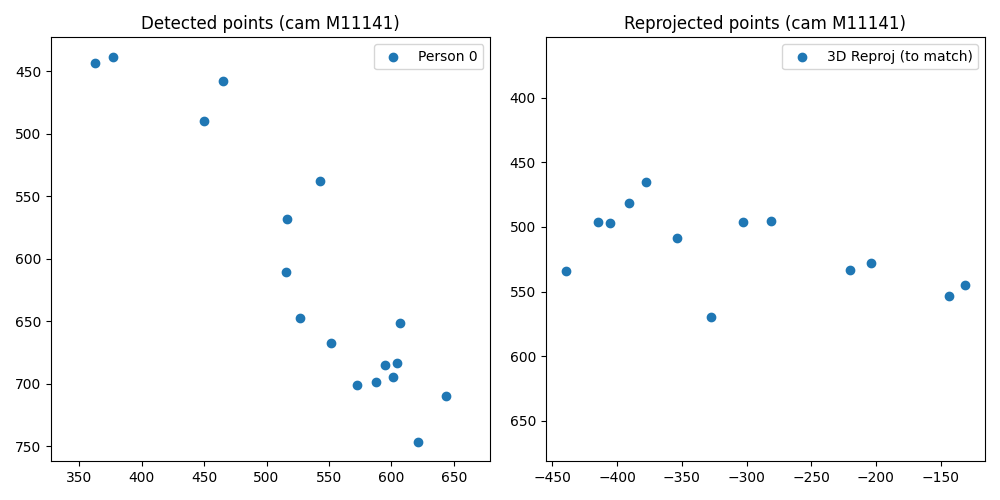

RMSE for cam M11458, person 0: 1023.03 pix


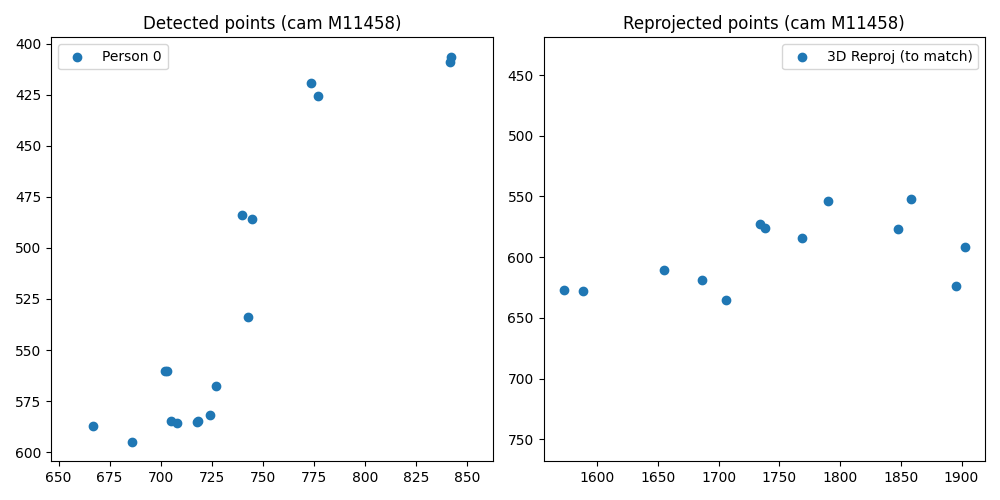

RMSE for cam M11459, person 0: 612.49 pix


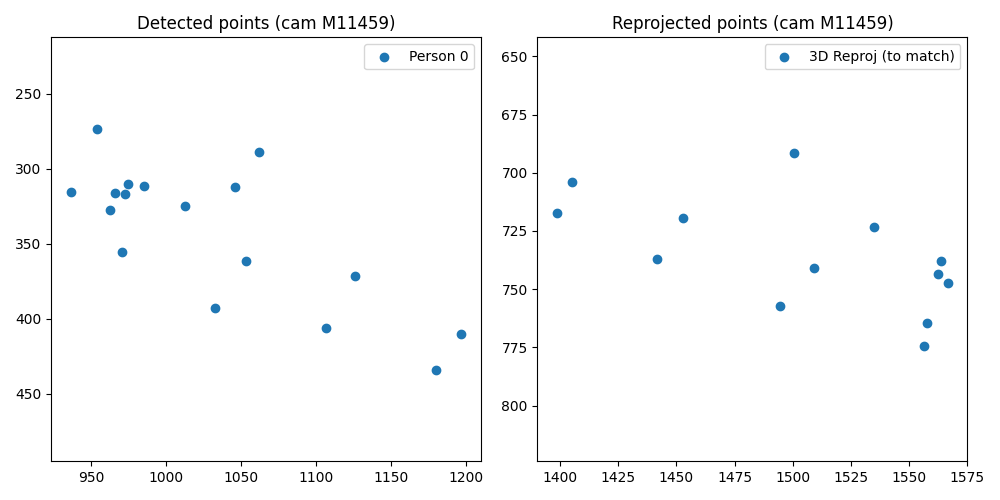

RMSE for cam M11461, person 0: 1830.15 pix


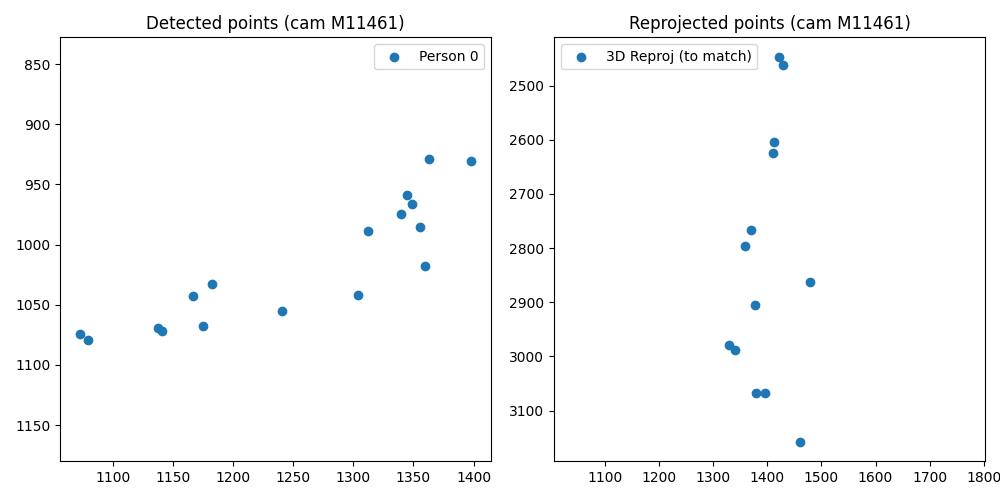

RMSE for cam M11462, person 0: 1077.03 pix


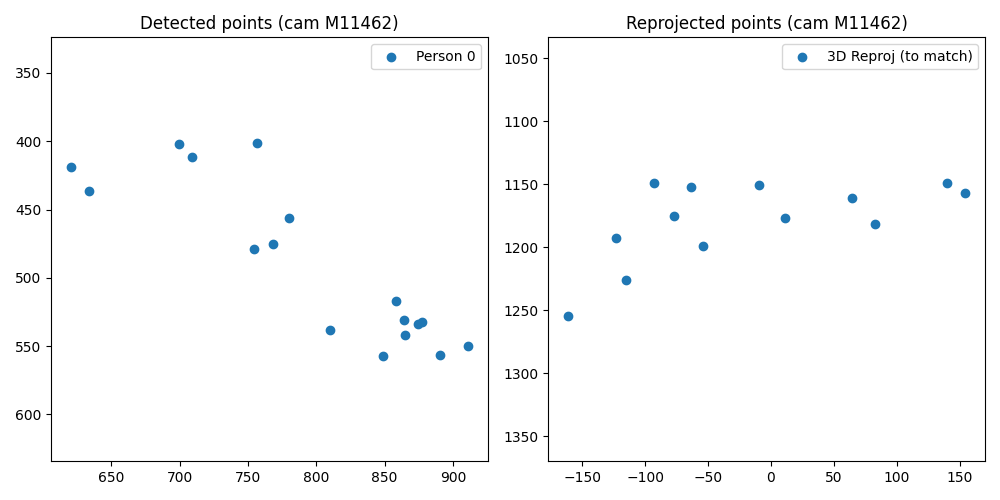

RMSE for cam M11463, person 0: 1938.82 pix


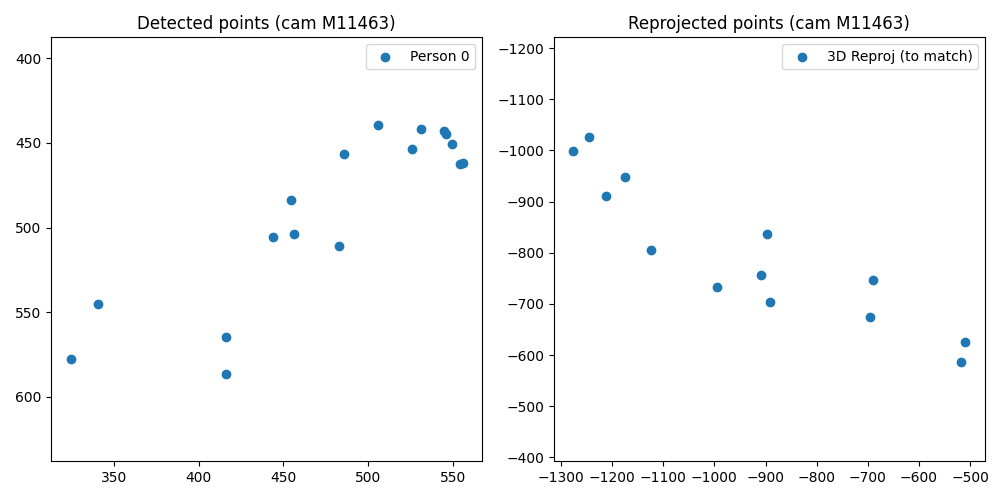

In [ ]:

projMat = [np.linalg.inv(mat) for mat in world_T_cam]
keypoints = {cam:{} for cam in cameras}

# Extract 3D keypoints from a frame
df, joints = load_trc("/home/lea/vitpose/Pose2Sim/pose-3d/Pose2Sim_0-1044.trc")

frame_idx = 348

points_3d = np.array([[df[f'{j}_X'].iloc[frame_idx], df[f'{j}_Y'].iloc[frame_idx], df[f'{j}_Z'].iloc[frame_idx]]
                      for j in joints])
points_3d_mm = points_3d * 1000 #convert to mm

# Create a list of indices where each 3D label appears in the 2D label list
labels_2d = ['Nose', 'LEye', 'REye', 'LEar', 'REar', 'LShoulder', 'RShoulder', 'LElbow', 'RElbow', 'LWrist', 'RWrist',
             'LHip', 'RHip', 'LKnee', 'RKnee', 'LAnkle', 'RAnkle']
labels_3d = ['RHip', 'RKnee', 'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'Nose', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
mapping_2d_to_3d = [labels_2d.index(label) for label in labels_3d]

""" # Extract 2D keypoints from a frame, for all cameras
path = '/home/lea/vitpose/Pose2Sim/pose-associated'
for dir in os.listdir(path):
    if os.path.isdir(os.path.join(path, dir)) and '_005-' in os.path.basename(dir):
        cam = dir.split('_')[-2]
        for file in os.listdir(os.path.join(path, dir)):
            if f'{frame_idx:06d}' in os.path.basename(file):
                print(cam, os.path.basename(dir), os.path.basename(file))
                (x_coords, y_coords), confidences = extract_keypoints(os.path.join(path, dir, file))
                keypoints[cam]['pts'] = (x_coords, y_coords)
                keypoints[cam]['conf'] = confidences """

points_3d = points_3d.T
Q = np.vstack((points_3d, np.ones((1, points_3d.shape[1]))))


for cam in cameras:
    i = cameras.index(cam)

    pts_reproj, mask = project_points_to_camera(points_3d_mm, K[i], projMat[i])

    try:
        pts_detect = keypoints_detections[frame_idx][cam]
    except KeyError:
        print(f'No detected points for cam {cam}')
        continue

    pts_detect = np.asarray(pts_detect).squeeze()

    if pts_detect.ndim == 2 and pts_detect.shape[0] == 17:
        # Only one person
        pts_detect = np.expand_dims(pts_detect, axis=0)  # Shape -> (1, 17, 2)

    if pts_detect.ndim != 3 or pts_detect.shape[1] != 17:
        print(f'Unexpected detection shape for cam {cam}: {pts_detect.shape}')
        continue

    colors = plt.get_cmap("tab10", pts_detect.shape[0])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    for pid, person_kpts in enumerate(pts_detect):  # Shape (17, 2)
        try:
            aligned_keypoints_2d = person_kpts[mapping_2d_to_3d, :]  # Shape (13, 2)
        except IndexError:
            print(f"Invalid keypoint structure for person {pid} in cam {cam}")
            continue

        # Compute RMSE between this person's aligned 2D and the reprojected 3D
        rmse = compute_rmse(aligned_keypoints_2d, pts_reproj)
        print(f'RMSE for cam {cam}, person {pid}: {rmse:.2f} pix')

        # Plot detected keypoints (left)
        ax1.scatter(person_kpts[:, 0], person_kpts[:, 1], label=f'Person {pid}', color=colors(pid))
        ax2.scatter(pts_reproj[:, 0], pts_reproj[:, 1], label=f'3D Reproj (to match)', color=colors(pid))

    ax1.set_title(f'Detected points (cam {cam})')
    ax2.set_title(f'Reprojected points (cam {cam})')
    for ax in [ax1, ax2]:
        ax.invert_yaxis()
        ax.axis('equal')
        ax.legend()

    plt.tight_layout()
    plt.show()


## Plot triangulated points Pose2Sim + camera views

In [ ]:
import multiview_consistency as mvc

%matplotlib widget

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / 20) for i in range(17)]

P_all = computeP('/home/lea/vitpose/Pose2Sim/Calibration/Calib.toml')

video_path = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429/'
root_path = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429_keypts/'

routine = '1_partie_0429_001'

if mvc.all_views_processed(root_path, routine):

    N_images = len(os.listdir(video_path+routine+'-Camera1_M11139'))
    frame_idx = 100

    keypts_cam = mvc.retrieve_keypts(root_path, routine)

    id_per_frame_per_cam = mvc.find_athlete(keypts_cam)
    keypts_per_cam = mvc.select_keypoints_athlete(keypts_cam, id_per_frame_per_cam)
    keypoints_detections = mvc.create_dict_all_detections(keypts_cam, N_images, cameras, id_per_frame_per_cam)

    """ # Extract 3D keypoints from Pose2Sim triangulation
    df, joints = load_trc("/home/lea/vitpose/Pose2Sim/pose-3d/Pose2Sim_0-1044.trc")

    points_3d_p2s = np.array([[df[f'{j}_X'].iloc[frame_idx], df[f'{j}_Y'].iloc[frame_idx], df[f'{j}_Z'].iloc[frame_idx]]
                        for j in joints])
    #print('Original Pose2Sim points')
    #print(points_3d_p2s)

    # Create 3D plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    R = np.array([[1,0,0], [0,0,-1], [0,1,0]])
    points_p2s_w = (R @ points_3d_p2s.T).T
    points_p2s_w *= 1000
    #print('Transformed Pose2Sim points')
    #print(points_p2s_w)

    for i, (x, y, z) in enumerate(points_p2s_w):
        ax.scatter(x, y, z, color=colors[i])
        ax.text(x, y, z, str(i), color='black')  # Optionnel : afficher l’indice du point  """
    

    # Dict for triangulated points per pair of cameras
    triangulated_points = {f'{c1}-{c2}':[] for c1 in range(8) for c2 in range(8) if c1 < c2}

    for c1 in range(8):
        for c2 in range(c1, 8):
            if c1 != c2:
                for frame_idx in range(N_images):
                    
                    try:
                        pts1 = np.asarray(keypoints_detections[frame_idx][cameras[c1]])[0, :, :]
                        pts2 = np.asarray(keypoints_detections[frame_idx][cameras[c2]])[0, :, :]
                    except KeyError:
                        continue
                    
                    P1 = P_all[c1]
                    P2 = P_all[c2]

                    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
                    points_3d = (points_4d[:3] / points_4d[3]).T  # Nx3
                    points_3d_h = np.hstack((points_3d, np.ones((points_3d.shape[0], 1)))).T  # 4xN

                    """ pts1_reproj_h = P1 @ points_3d_h  # 3xN
                    pts1_reproj = (pts1_reproj_h[:2] / pts1_reproj_h[2]).T  # Nx2

                    pts2_reproj_h = P2 @ points_3d_h  # 3xN
                    pts2_reproj = (pts2_reproj_h[:2] / pts2_reproj_h[2]).T  # Nx2 """

                    #points_3d *= 1000
                    #draw_keypoints(points_3d, colors)
                    #draw_skeleton(points_3d, colors[c1])

                    triangulated_points[f'{c1}-{c2}'].append(points_3d)
            
        #break

    """ for i, T in enumerate(world_T_cam):
        draw_camera(ax, T, color=colors[i % len(colors)])

    ax.set_xlabel('X (mm)')
    ax.set_ylabel('Y (mm)')
    ax.set_zlabel('Z (mm)')
    ax.set_xlim(-8000, 8000)
    ax.set_ylim(-8000, 8000)
    ax.set_zlim(0, 8000)
    ax.set_title('3D triangulated points')
    #ax.legend()
    #ax.axis('equal')
    plt.show() """


### MPJPE on triangulated points

M11139 - M11140


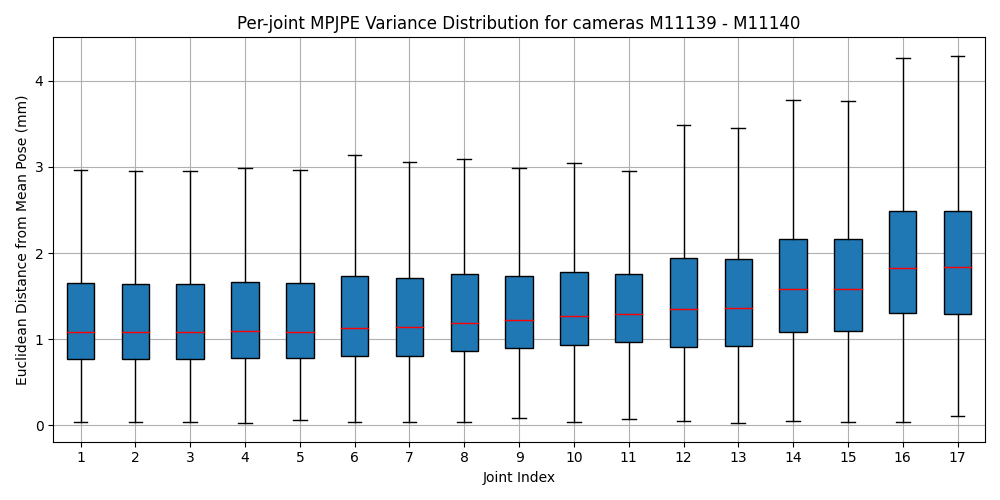

{'N': 146072, 'mean_joint_variance': 1.4642134846262447, 'min_joint_variance': 0.024029650144415864, 'max_joint_variance': 7.407892494541547, 'jointwise_mean': array([1.2527, 1.2535, 1.2526, 1.2806, 1.2723, 1.3196, 1.3213, 1.3622,
       1.387 , 1.4033, 1.4291, 1.5062, 1.5054, 1.7061, 1.7061, 1.967 ,
       1.9667]), 'jointwise_median': array([1.0855, 1.0858, 1.0844, 1.0958, 1.0874, 1.1275, 1.138 , 1.1915,
       1.2225, 1.2671, 1.2943, 1.3547, 1.365 , 1.585 , 1.5832, 1.8267,
       1.8352]), 'jointwise_min': array([0.0359, 0.0374, 0.0412, 0.024 , 0.0615, 0.0407, 0.0405, 0.0349,
       0.0858, 0.0361, 0.0708, 0.0475, 0.0296, 0.0551, 0.0417, 0.0365,
       0.1125]), 'jointwise_max': array([4.2987, 4.3009, 4.3317, 4.8433, 4.5516, 4.5311, 4.2862, 4.7391,
       4.5733, 4.7811, 4.8223, 5.0207, 5.0217, 6.0907, 5.7107, 7.4079,
       6.4832]), 'jointwise_q1': array([0.7724, 0.7714, 0.7712, 0.7791, 0.7792, 0.8004, 0.8038, 0.8673,
       0.8952, 0.9278, 0.9659, 0.9146, 0.921 , 1.0893, 1.0925, 

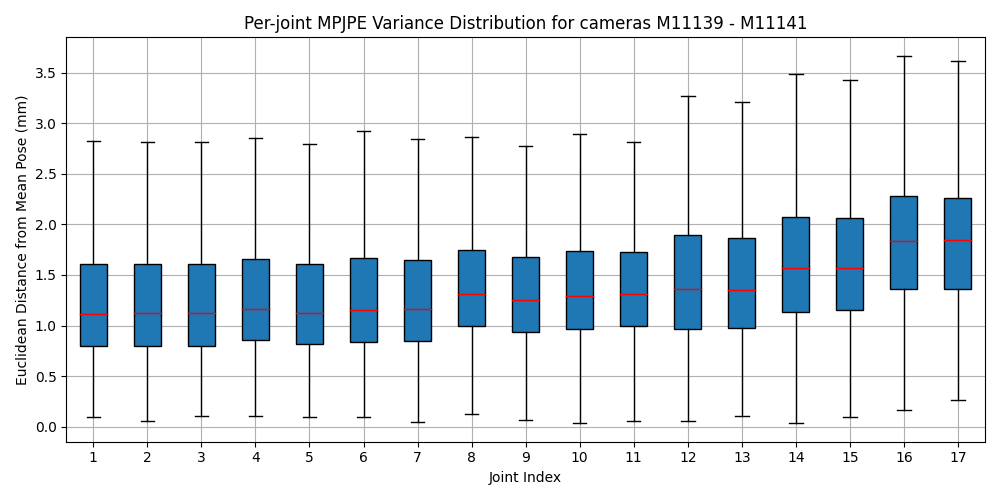

{'N': 192592, 'mean_joint_variance': 1.4724955571058769, 'min_joint_variance': 0.03189071020863429, 'max_joint_variance': 4535.44881956622, 'jointwise_mean': array([1.273 , 1.2603, 1.2652, 1.4103, 1.2945, 1.3349, 1.3293, 1.628 ,
       1.3812, 1.3967, 1.4158, 1.4918, 1.4862, 1.6538, 1.6618, 1.8717,
       1.8778]), 'jointwise_median': array([1.1167, 1.1195, 1.119 , 1.1607, 1.1266, 1.158 , 1.1612, 1.3117,
       1.2485, 1.2955, 1.3113, 1.3596, 1.3547, 1.5706, 1.5709, 1.8362,
       1.8431]), 'jointwise_min': array([0.0972, 0.0591, 0.1039, 0.1041, 0.0976, 0.0931, 0.0494, 0.1229,
       0.0674, 0.0319, 0.0593, 0.0563, 0.1086, 0.0326, 0.0935, 0.1674,
       0.2583]), 'jointwise_max': array([ 441.238 ,  105.4736,  165.1909, 2384.6919,  211.9628,  339.2508,
        141.497 , 4535.4488,   18.8462,  126.4077,   24.4177,  202.7277,
         19.5201,   20.4291,   13.7342,   12.6909,   14.5178]), 'jointwise_q1': array([0.7924, 0.7998, 0.7984, 0.8606, 0.8169, 0.8396, 0.8462, 0.9972,
       0.9351,

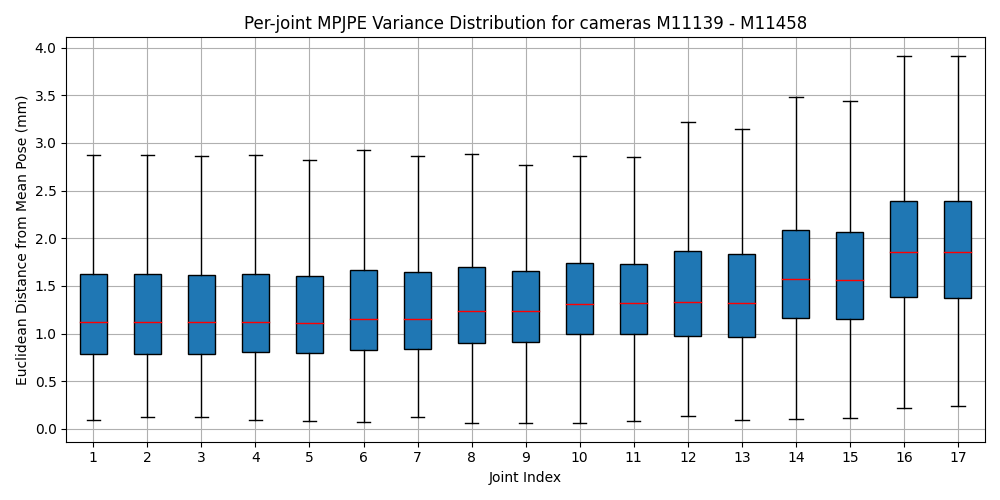

{'N': 152216, 'mean_joint_variance': 1.5481789964604828, 'min_joint_variance': 0.05792006053432799, 'max_joint_variance': 366.467548831896, 'jointwise_mean': array([1.337 , 1.3393, 1.3362, 1.3723, 1.3528, 1.4108, 1.4184, 1.4857,
       1.4654, 1.5171, 1.5179, 1.5829, 1.579 , 1.773 , 1.7729, 2.0288,
       2.0295]), 'jointwise_median': array([1.1256, 1.1245, 1.1184, 1.1193, 1.1105, 1.1514, 1.1565, 1.2336,
       1.2398, 1.312 , 1.316 , 1.3342, 1.3208, 1.5699, 1.5652, 1.8522,
       1.8522]), 'jointwise_min': array([0.0932, 0.1197, 0.1225, 0.095 , 0.0779, 0.0671, 0.1292, 0.0656,
       0.0667, 0.0579, 0.0825, 0.1382, 0.0936, 0.1065, 0.1109, 0.2163,
       0.2429]), 'jointwise_max': array([ 29.554 ,  32.5092,  30.876 ,  64.0149,  34.3819,  65.1672,
       366.4675, 170.6237,  31.9952, 181.7244,  23.8718, 168.297 ,
       304.318 ,  88.506 , 106.0913,  59.3645,  77.35  ]), 'jointwise_q1': array([0.7903, 0.7899, 0.7867, 0.8032, 0.794 , 0.8293, 0.8352, 0.904 ,
       0.9165, 0.9986, 0.9925, 

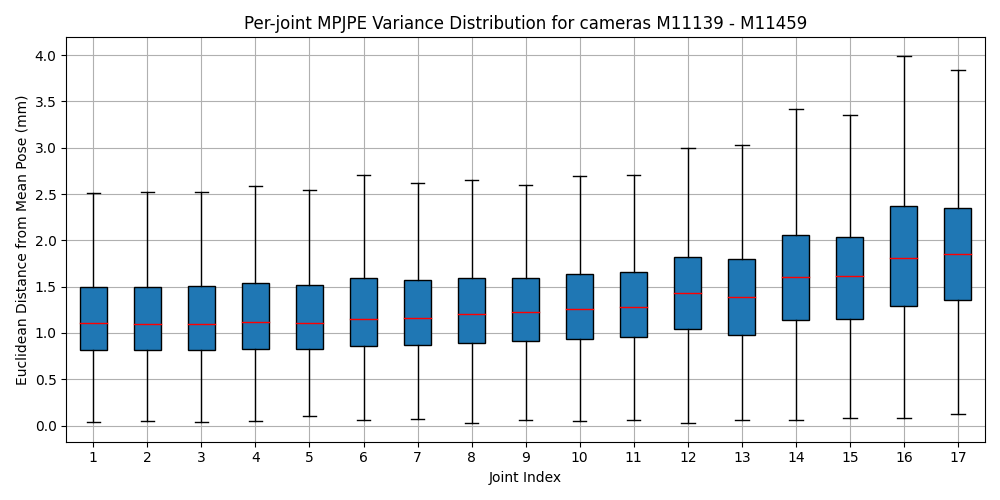

{'N': 97072, 'mean_joint_variance': 1.4481741741152987, 'min_joint_variance': 0.024070276928255273, 'max_joint_variance': 1311.320743390828, 'jointwise_mean': array([1.1955, 1.196 , 1.197 , 1.2275, 1.2215, 1.2704, 1.2772, 1.2991,
       1.3361, 1.3283, 1.3676, 1.7332, 1.551 , 1.658 , 1.674 , 1.9869,
       2.0998]), 'jointwise_median': array([1.1021, 1.102 , 1.1   , 1.1165, 1.1126, 1.1535, 1.1585, 1.2033,
       1.2273, 1.262 , 1.2762, 1.4274, 1.3876, 1.6007, 1.6168, 1.8134,
       1.8546]), 'jointwise_min': array([0.0336, 0.0503, 0.0362, 0.0469, 0.1045, 0.0631, 0.0742, 0.0329,
       0.0582, 0.0511, 0.0563, 0.0241, 0.0638, 0.0555, 0.0818, 0.0863,
       0.1273]), 'jointwise_max': array([   4.7082,    5.4019,    4.7281,    6.0265,    5.708 ,    9.0381,
         29.7186,   17.1772,   23.3434,   21.2132,   75.2333, 1311.3207,
        681.7248,   98.7709,  152.867 ,  855.5254,  999.2855]), 'jointwise_q1': array([0.8193, 0.8169, 0.8189, 0.8265, 0.832 , 0.854 , 0.8659, 0.8935,
       0.9183

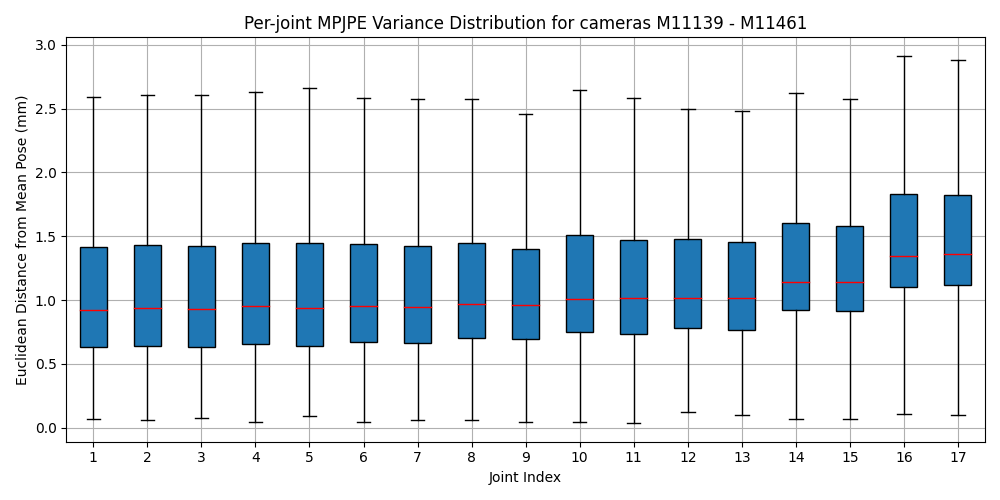

{'N': 109384, 'mean_joint_variance': 1.2938592152758155, 'min_joint_variance': 0.03404227081942432, 'max_joint_variance': 518.5201671266558, 'jointwise_mean': array([1.1575, 1.163 , 1.1633, 1.1873, 1.1816, 1.2045, 1.2058, 1.2195,
       1.2336, 1.2471, 1.2586, 1.3047, 1.3019, 1.427 , 1.4304, 1.6652,
       1.6447]), 'jointwise_median': array([0.9246, 0.9355, 0.9327, 0.9502, 0.9399, 0.9543, 0.9429, 0.9661,
       0.9603, 1.0064, 1.0127, 1.0121, 1.0167, 1.1441, 1.1396, 1.3474,
       1.3612]), 'jointwise_min': array([0.0663, 0.0577, 0.0793, 0.0438, 0.0932, 0.0458, 0.0635, 0.0618,
       0.0434, 0.0445, 0.034 , 0.1239, 0.1027, 0.0672, 0.0667, 0.11  ,
       0.0992]), 'jointwise_max': array([  5.9902,   5.8947,   5.9099,   5.8701,   6.0414,   7.5092,
         7.0709,   6.9544,   7.555 ,   7.9418,  11.1824,   7.8092,
         7.2966,  16.5754,  25.458 , 518.5202, 134.6724]), 'jointwise_q1': array([0.6345, 0.6405, 0.6354, 0.6527, 0.6375, 0.6709, 0.6596, 0.7001,
       0.6919, 0.7493, 0.7308,

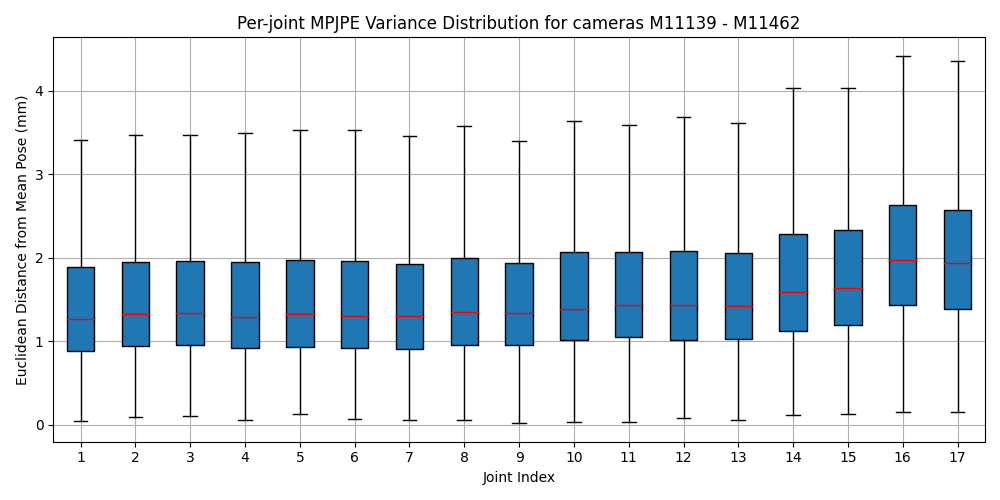

{'N': 169496, 'mean_joint_variance': 1.9064629508152702, 'min_joint_variance': 0.01685506841650807, 'max_joint_variance': 3413.148721107896, 'jointwise_mean': array([1.6982, 1.8494, 1.8376, 1.7543, 1.8048, 1.8466, 1.7485, 1.7848,
       1.844 , 1.8437, 1.8481, 1.8778, 1.8787, 2.0471, 2.0936, 2.3952,
       2.2575]), 'jointwise_median': array([1.2628, 1.3263, 1.3345, 1.2936, 1.3244, 1.3069, 1.305 , 1.3514,
       1.3399, 1.3908, 1.4367, 1.4344, 1.4258, 1.5872, 1.6435, 1.974 ,
       1.9383]), 'jointwise_min': array([0.039 , 0.092 , 0.1038, 0.0607, 0.1262, 0.0714, 0.052 , 0.0596,
       0.0169, 0.0274, 0.0298, 0.0866, 0.0537, 0.1153, 0.1281, 0.149 ,
       0.1482]), 'jointwise_max': array([ 291.3299, 2348.9071, 1361.808 ,  718.1612, 1527.918 , 1842.5434,
        285.6132,  264.4279, 1127.2648,  294.7275,  507.7582,  376.5327,
        384.2971,  531.5404,  797.3583, 3413.1487, 1179.1219]), 'jointwise_q1': array([0.8813, 0.9426, 0.9526, 0.9148, 0.9312, 0.9227, 0.9112, 0.9498,
       0.9541

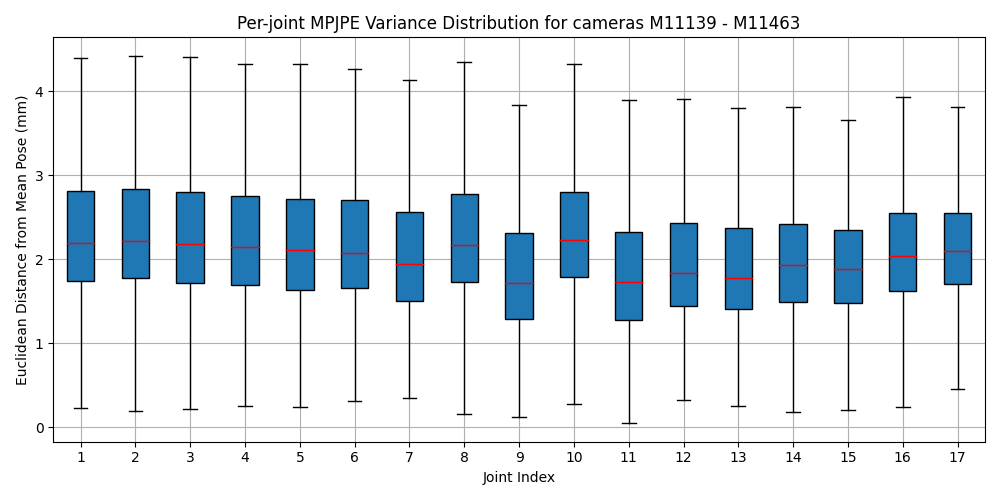

{'N': 125032, 'mean_joint_variance': 3.1019129211093084, 'min_joint_variance': 0.04628200272381928, 'max_joint_variance': 3139.9340424342354, 'jointwise_mean': array([3.4864, 3.5475, 3.4749, 3.4471, 3.4138, 3.2934, 2.9622, 3.3415,
       2.8091, 3.943 , 2.9616, 2.6984, 2.6091, 2.6393, 2.5378, 2.7571,
       2.8103]), 'jointwise_median': array([2.191 , 2.2232, 2.1862, 2.1457, 2.1163, 2.0738, 1.9423, 2.1659,
       1.719 , 2.2303, 1.7241, 1.8394, 1.7788, 1.9344, 1.8807, 2.041 ,
       2.1016]), 'jointwise_min': array([0.2329, 0.1974, 0.2142, 0.2479, 0.2391, 0.311 , 0.3425, 0.0737,
       0.1183, 0.2149, 0.0463, 0.3213, 0.2567, 0.1862, 0.2045, 0.2154,
       0.2034]), 'jointwise_max': array([ 684.5753,  144.1964,  225.2175,  376.8822, 1032.2115,  460.1584,
        598.414 ,  255.0544, 2166.6434, 3139.934 , 1750.545 ,   76.0464,
         65.5268,  155.2034,   57.7504,  885.8102, 1279.5015]), 'jointwise_q1': array([1.7441, 1.7826, 1.7173, 1.6954, 1.6349, 1.6588, 1.503 , 1.7311,
       1.291

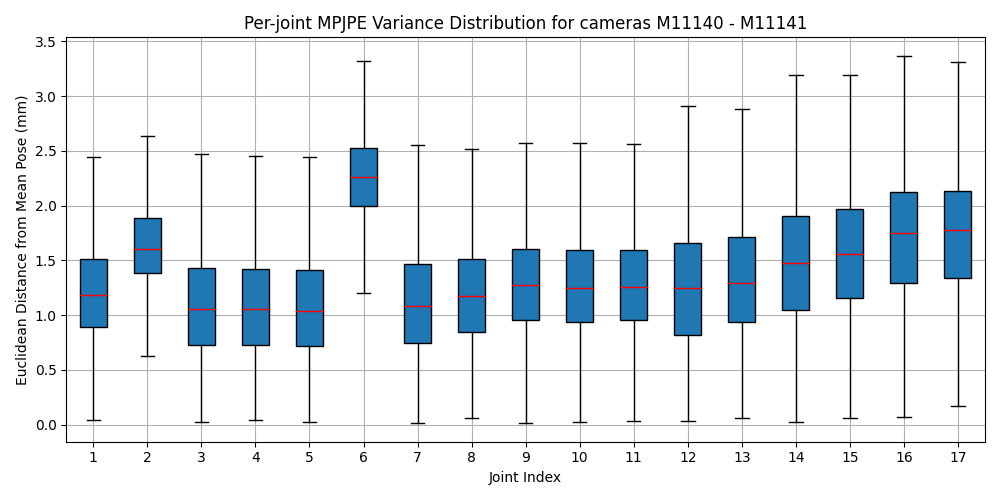

{'N': 237648, 'mean_joint_variance': 2.2333714475091293, 'min_joint_variance': 0.012689165785037234, 'max_joint_variance': 53287.05228547625, 'jointwise_mean': array([2.4024, 3.4931, 1.5633, 1.7306, 1.6152, 4.4249, 1.5309, 1.7098,
       2.1693, 1.7669, 1.852 , 1.7304, 1.9642, 2.7533, 2.465 , 2.3623,
       2.4338]), 'jointwise_median': array([1.1841, 1.6053, 1.0572, 1.0534, 1.0359, 2.2593, 1.0889, 1.1713,
       1.2724, 1.2471, 1.2598, 1.2477, 1.2956, 1.4748, 1.5591, 1.7466,
       1.7822]), 'jointwise_min': array([0.041 , 0.3209, 0.0254, 0.0432, 0.0246, 0.1395, 0.0127, 0.0623,
       0.0197, 0.0234, 0.0368, 0.0298, 0.0633, 0.0211, 0.0653, 0.0691,
       0.1342]), 'jointwise_max': array([19594.6531, 32568.8498,  2996.9074,  3174.6389,  1464.7989,
       53287.0523,   688.6561,  2453.4182, 10362.971 ,  1952.0548,
         796.3242,   828.2153,  5328.6805, 18917.0192, 11430.8566,
        1567.1997,  1431.8873]), 'jointwise_q1': array([0.8957, 1.3825, 0.7302, 0.7304, 0.7223, 1.9989, 0.74

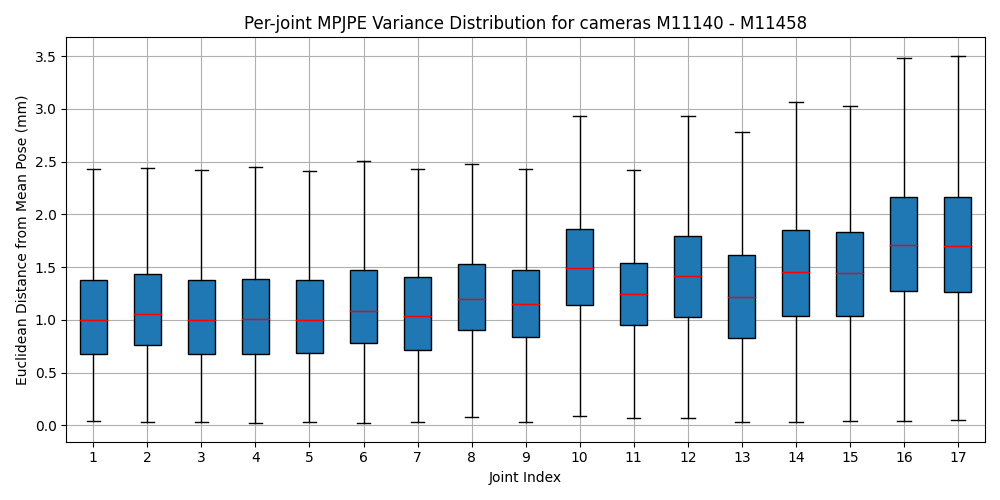

{'N': 196936, 'mean_joint_variance': 1.9022425526412265, 'min_joint_variance': 0.02002401875921408, 'max_joint_variance': 17906.992683478235, 'jointwise_mean': array([1.4646, 1.9771, 1.5723, 1.4875, 1.4181, 1.7954, 1.5003, 2.112 ,
       1.6894, 2.6166, 1.811 , 2.3854, 1.7008, 2.0722, 1.9274, 2.1703,
       2.6376]), 'jointwise_median': array([1.0014, 1.0604, 1.0009, 1.0047, 0.9978, 1.0836, 1.0346, 1.199 ,
       1.1476, 1.4938, 1.2478, 1.4211, 1.2145, 1.4512, 1.4407, 1.7055,
       1.6969]), 'jointwise_min': array([0.0412, 0.0337, 0.0297, 0.02  , 0.0346, 0.0274, 0.0281, 0.0803,
       0.0362, 0.0902, 0.0569, 0.0675, 0.0315, 0.0355, 0.0406, 0.0429,
       0.0505]), 'jointwise_max': array([ 1031.0289, 10125.0758,  3474.9978,   888.7234,   616.6623,
        6263.5024,  1005.1702, 11006.158 ,  1932.4639, 17906.9927,
        4050.4033, 13396.5714,  2044.808 ,  2009.4059,  1013.6219,
         919.9364,  7564.4485]), 'jointwise_q1': array([0.6788, 0.7616, 0.6792, 0.679 , 0.6839, 0.7803, 0.71

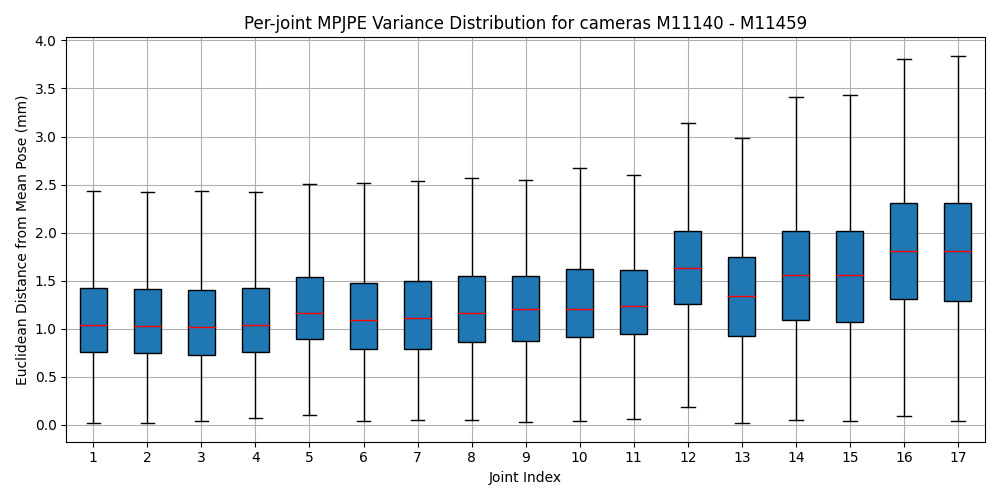

{'N': 131688, 'mean_joint_variance': 1.6182118980402864, 'min_joint_variance': 0.016970979002022598, 'max_joint_variance': 15800.096378564323, 'jointwise_mean': array([1.2388, 1.2231, 1.4222, 1.2249, 1.6604, 1.2817, 1.3962, 1.3674,
       1.7862, 1.4081, 1.4453, 2.912 , 1.589 , 1.6959, 1.6988, 2.1805,
       1.9792]), 'jointwise_median': array([1.0423, 1.0312, 1.0205, 1.04  , 1.1609, 1.0962, 1.1095, 1.1604,
       1.2033, 1.2025, 1.2373, 1.6346, 1.3419, 1.5572, 1.5645, 1.8131,
       1.8133]), 'jointwise_min': array([0.0213, 0.0237, 0.0437, 0.0706, 0.1065, 0.0395, 0.0475, 0.0473,
       0.0281, 0.0428, 0.0571, 0.086 , 0.017 , 0.0502, 0.0438, 0.0895,
       0.0423]), 'jointwise_max': array([  525.9601,   274.3995,  3673.3141,   228.5781,  5782.9959,
         209.7101,   794.274 ,   358.4416,  2875.5659,   219.2964,
         140.3008, 15800.0964,  1509.6696,   114.2531,    96.7585,
        2394.5479,   152.1934]), 'jointwise_q1': array([0.7578, 0.7456, 0.7253, 0.7545, 0.8907, 0.7887, 0.7

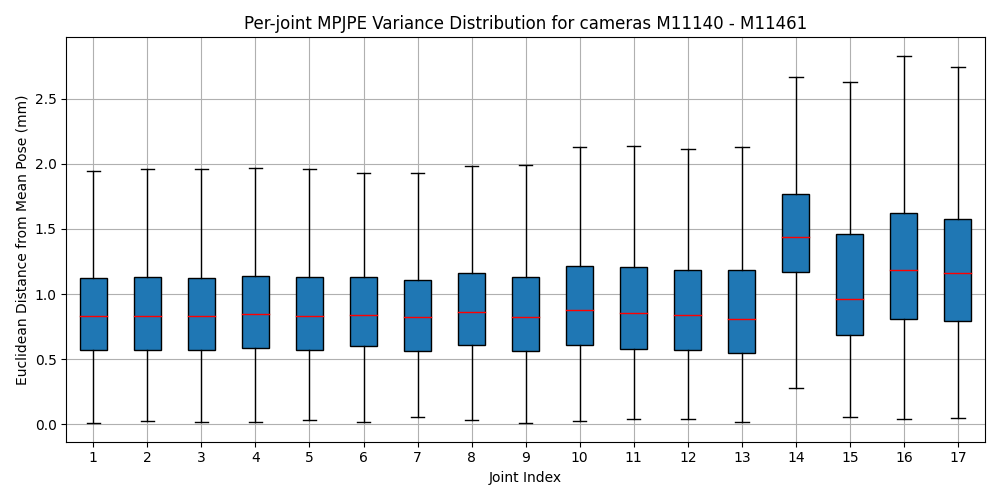

{'N': 122704, 'mean_joint_variance': 1.320673909450351, 'min_joint_variance': 0.006489126304214427, 'max_joint_variance': 18221.386575823853, 'jointwise_mean': array([0.9553, 0.9661, 0.9601, 0.9924, 0.9631, 1.0164, 0.9684, 1.0859,
       1.0015, 1.1506, 1.0586, 1.1146, 1.094 , 2.9976, 1.986 , 2.1886,
       1.9522]), 'jointwise_median': array([0.8282, 0.8345, 0.8333, 0.8497, 0.8332, 0.8401, 0.8214, 0.863 ,
       0.8273, 0.8782, 0.8545, 0.8368, 0.8077, 1.4387, 0.9642, 1.1833,
       1.1649]), 'jointwise_min': array([0.0122, 0.0261, 0.0171, 0.0154, 0.0305, 0.0147, 0.0514, 0.0295,
       0.0065, 0.0266, 0.0432, 0.038 , 0.0185, 0.1723, 0.0574, 0.0407,
       0.0448]), 'jointwise_max': array([   15.4172,    10.958 ,    73.5338,    10.4993,    11.7428,
          39.3759,    12.2158,   639.8621,    12.7525,   579.1445,
         148.3498,   144.67  ,   104.7887, 18221.3866,  5376.3843,
        3382.0504,  1128.4641]), 'jointwise_q1': array([0.5663, 0.5726, 0.569 , 0.5866, 0.57  , 0.6009, 0.56

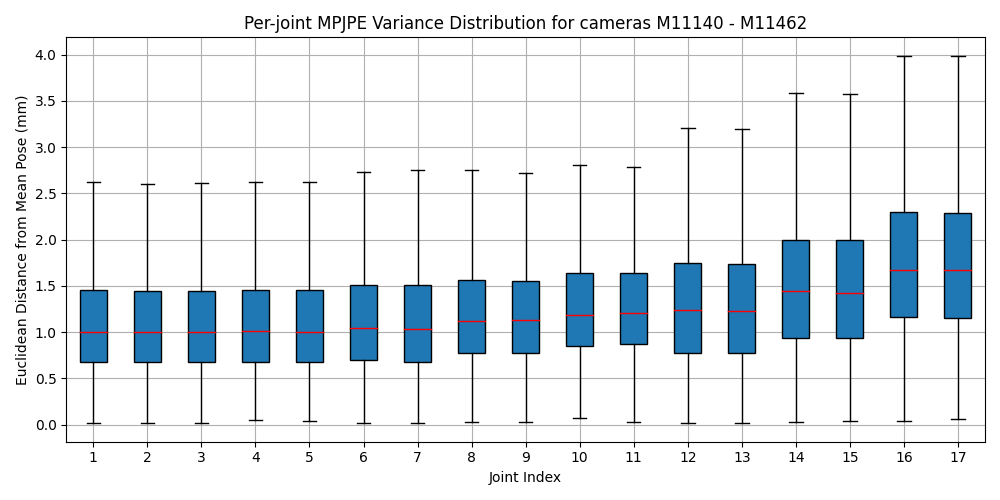

{'N': 187536, 'mean_joint_variance': 1.3487410485311695, 'min_joint_variance': 0.013854961332801842, 'max_joint_variance': 528.642642190701, 'jointwise_mean': array([1.141 , 1.1414, 1.14  , 1.1622, 1.1505, 1.1994, 1.1887, 1.2711,
       1.2643, 1.3168, 1.3259, 1.3688, 1.3621, 1.5835, 1.574 , 1.8667,
       1.872 ]), 'jointwise_median': array([1.0039, 1.0027, 0.9989, 1.0099, 0.9985, 1.0487, 1.0387, 1.1197,
       1.1335, 1.1814, 1.2093, 1.2381, 1.2296, 1.4396, 1.4261, 1.6766,
       1.6695]), 'jointwise_min': array([0.0156, 0.0139, 0.0185, 0.0492, 0.0362, 0.0168, 0.0183, 0.0277,
       0.0279, 0.0679, 0.0299, 0.0214, 0.0169, 0.0273, 0.0339, 0.0382,
       0.0631]), 'jointwise_max': array([  7.3847,   8.6623,   7.2874,   8.6835,   7.6405,   8.7034,
         7.028 , 251.0847,   7.0621,  16.6641,   8.4694,   7.4706,
        12.6492, 263.3851,  64.8602, 528.6426, 379.1124]), 'jointwise_q1': array([0.6753, 0.6764, 0.6759, 0.6823, 0.6733, 0.6999, 0.681 , 0.7729,
       0.7754, 0.8532, 0.8685,

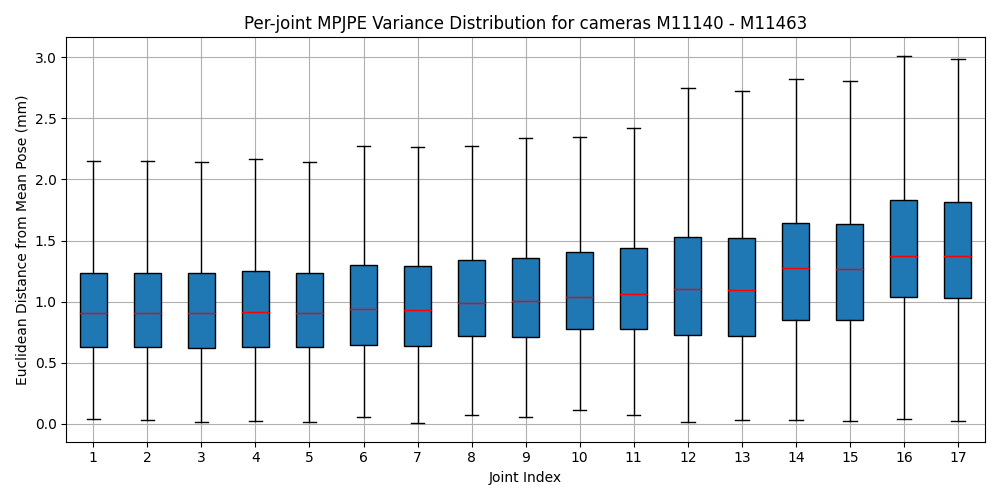

{'N': 142160, 'mean_joint_variance': 1.1192114807888858, 'min_joint_variance': 0.005061761566766588, 'max_joint_variance': 39.33597353359953, 'jointwise_mean': array([0.9681, 0.9693, 0.9633, 0.9796, 0.9645, 1.0115, 0.9938, 1.0691,
       1.0606, 1.1234, 1.1269, 1.1494, 1.1376, 1.2937, 1.2839, 1.4727,
       1.459 ]), 'jointwise_median': array([0.9079, 0.9087, 0.907 , 0.9185, 0.9083, 0.9394, 0.9316, 0.9907,
       1.0019, 1.0371, 1.0618, 1.0999, 1.0961, 1.2787, 1.2676, 1.3744,
       1.3713]), 'jointwise_min': array([0.0408, 0.0345, 0.0199, 0.0243, 0.0121, 0.0581, 0.0051, 0.0713,
       0.0539, 0.1157, 0.0694, 0.0187, 0.0306, 0.0285, 0.0225, 0.0371,
       0.0253]), 'jointwise_max': array([ 4.2949,  4.377 ,  4.3057,  4.6704,  4.6488,  5.0535,  4.8395,
        8.5201,  4.3528,  5.6779, 39.336 ,  6.4518,  5.8688,  5.999 ,
        5.5689,  7.9788,  5.3315]), 'jointwise_q1': array([0.6276, 0.6259, 0.6237, 0.6331, 0.6255, 0.6497, 0.6353, 0.721 ,
       0.7097, 0.7774, 0.7778, 0.7245, 0.7217,

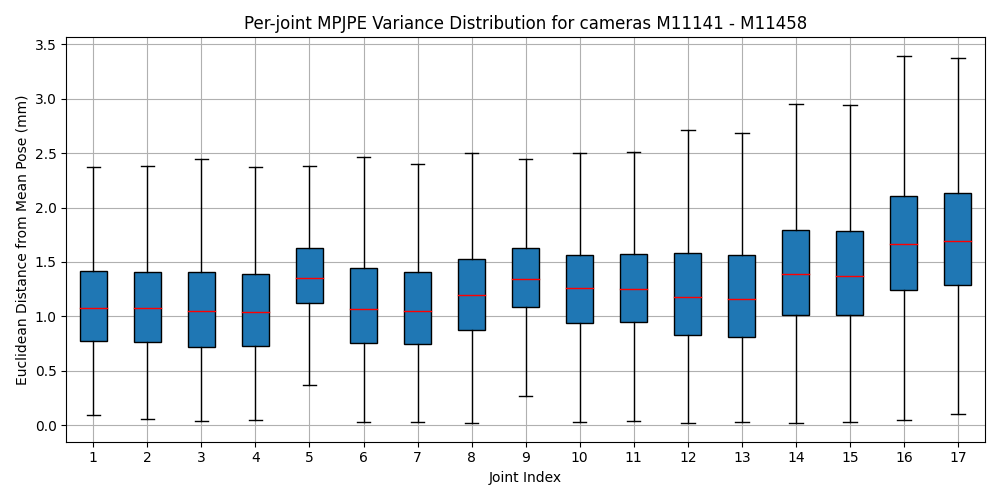

{'N': 253744, 'mean_joint_variance': 2.0655407418370366, 'min_joint_variance': 0.018486506032967462, 'max_joint_variance': 19900.588189824066, 'jointwise_mean': array([1.8543, 2.1977, 2.0841, 1.7603, 2.8278, 1.9632, 1.9463, 2.116 ,
       2.5907, 2.174 , 1.9969, 1.7678, 1.5364, 1.7218, 1.8177, 2.3059,
       2.4533]), 'jointwise_median': array([1.0814, 1.0741, 1.0524, 1.0376, 1.3519, 1.0723, 1.0501, 1.1928,
       1.3479, 1.2621, 1.2514, 1.1782, 1.1583, 1.3866, 1.372 , 1.6632,
       1.6935]), 'jointwise_min': array([0.0917, 0.0577, 0.0392, 0.0481, 0.0625, 0.0287, 0.0345, 0.0217,
       0.0222, 0.03  , 0.0429, 0.0233, 0.0324, 0.0185, 0.0342, 0.0482,
       0.1049]), 'jointwise_max': array([ 5421.9676,  8239.8776,  7495.7022,  2080.4286, 19900.5882,
        4282.767 ,  3993.7308,  8660.5339, 17621.4981,  6392.026 ,
        1863.2678,  6041.3959,   518.2643,   533.3056,  1291.472 ,
        9884.0903,  6961.051 ]), 'jointwise_q1': array([0.777 , 0.763 , 0.7222, 0.7283, 1.1225, 0.7597, 0.7

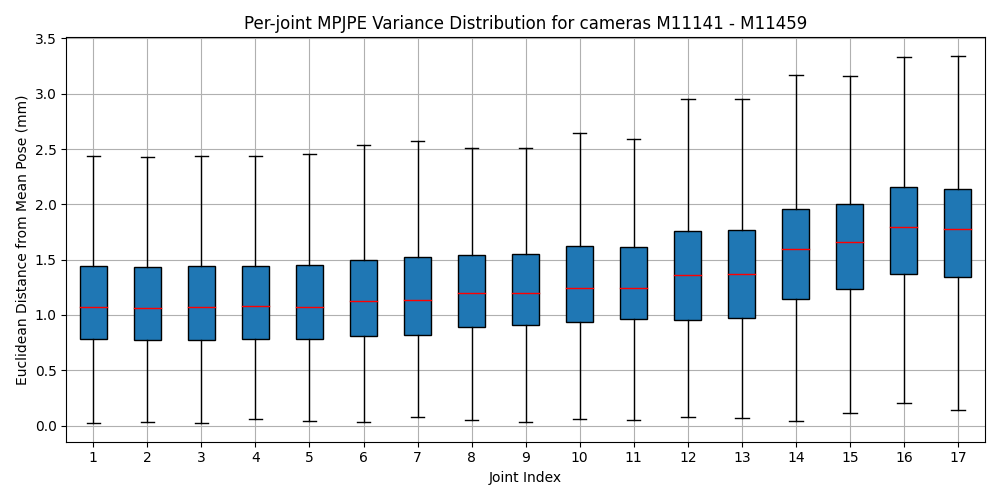

{'N': 170360, 'mean_joint_variance': 1.446783951545365, 'min_joint_variance': 0.020362490522559715, 'max_joint_variance': 7205.456726496211, 'jointwise_mean': array([1.1875, 1.1846, 1.1834, 1.203 , 1.1988, 1.2876, 1.2587, 1.3632,
       1.3306, 1.3635, 1.5347, 1.5039, 1.4787, 1.636 , 2.1189, 1.9513,
       1.811 ]), 'jointwise_median': array([1.0716, 1.0674, 1.0677, 1.0792, 1.0736, 1.1261, 1.1318, 1.1942,
       1.202 , 1.2459, 1.2462, 1.3591, 1.366 , 1.593 , 1.6614, 1.7923,
       1.7752]), 'jointwise_min': array([0.0204, 0.033 , 0.0236, 0.0619, 0.0384, 0.0293, 0.0754, 0.0527,
       0.0354, 0.0603, 0.0519, 0.0771, 0.0694, 0.0425, 0.0432, 0.1107,
       0.0705]), 'jointwise_max': array([  16.4024,   15.1987,   16.1665,   17.3512,   17.4525,  656.5621,
         92.5716,  568.636 ,  440.4211,  125.5447, 3422.7988,  615.7576,
        190.6582,  149.9864, 7205.4567, 1158.4349,   72.1877]), 'jointwise_q1': array([0.78  , 0.7752, 0.7735, 0.7862, 0.7824, 0.8108, 0.8234, 0.8936,
       0.9073

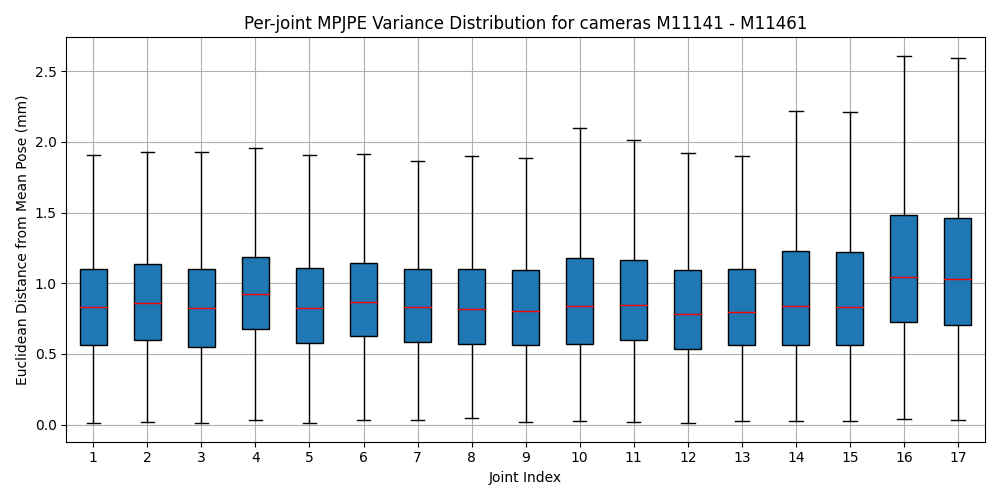

{'N': 193216, 'mean_joint_variance': 1.4320333566263266, 'min_joint_variance': 0.009414807690471389, 'max_joint_variance': 6976.450509490033, 'jointwise_mean': array([1.1138, 1.263 , 1.145 , 1.8119, 1.3952, 1.4516, 1.3091, 1.3509,
       1.2455, 1.2866, 1.2947, 1.318 , 1.3465, 1.3777, 1.3662, 1.9812,
       2.2878]), 'jointwise_median': array([0.829 , 0.8635, 0.8223, 0.9249, 0.8271, 0.8664, 0.8287, 0.8193,
       0.8046, 0.8405, 0.8482, 0.7837, 0.7956, 0.8411, 0.8331, 1.0461,
       1.0291]), 'jointwise_min': array([0.0094, 0.0172, 0.0131, 0.0329, 0.0101, 0.0365, 0.0312, 0.0461,
       0.0207, 0.0225, 0.0183, 0.0148, 0.0234, 0.0278, 0.0254, 0.0404,
       0.0339]), 'jointwise_max': array([ 797.1339, 2953.3558, 1767.9266, 6976.4505, 4814.7978, 3808.2756,
       1862.3156,  800.0842,  861.1379,  628.7463, 2827.8515, 1041.3792,
       2908.246 , 1026.7634,  789.2961, 4769.5819, 4612.2679]), 'jointwise_q1': array([0.5617, 0.5997, 0.5524, 0.6756, 0.5774, 0.6284, 0.5856, 0.57  ,
       0.562

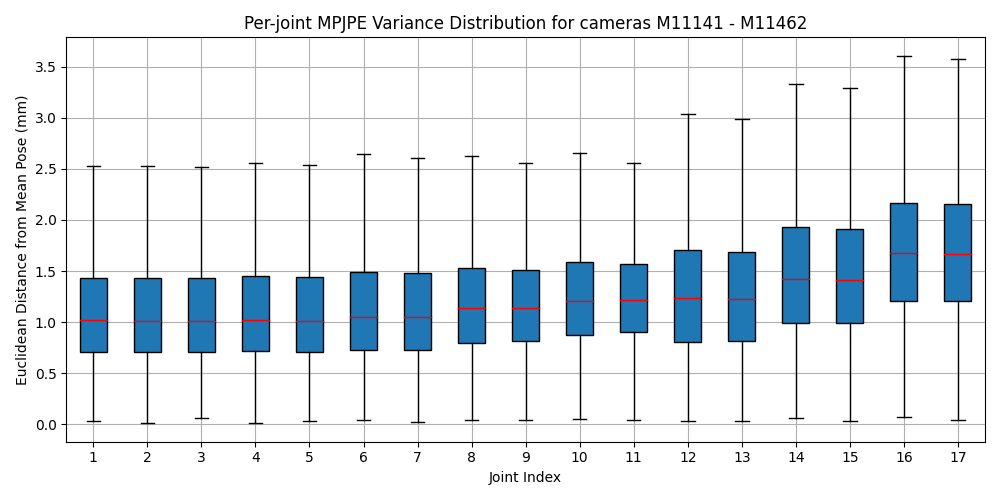

{'N': 269960, 'mean_joint_variance': 1.30677968857269, 'min_joint_variance': 0.009695909622158083, 'max_joint_variance': 16.74148679347293, 'jointwise_mean': array([1.1289, 1.1294, 1.1282, 1.1478, 1.1379, 1.1811, 1.1735, 1.235 ,
       1.2421, 1.287 , 1.297 , 1.3358, 1.3331, 1.5124, 1.5084, 1.7215,
       1.7164]), 'jointwise_median': array([1.0184, 1.0155, 1.0146, 1.0208, 1.011 , 1.055 , 1.0455, 1.1384,
       1.1375, 1.2071, 1.2171, 1.2358, 1.2276, 1.4247, 1.4135, 1.6808,
       1.6717]), 'jointwise_min': array([0.0282, 0.0143, 0.0577, 0.0097, 0.0339, 0.0388, 0.0244, 0.0425,
       0.0418, 0.0532, 0.0461, 0.0329, 0.0347, 0.0668, 0.0366, 0.0702,
       0.0411]), 'jointwise_max': array([ 5.3022,  4.9003,  5.126 ,  4.7092,  4.6278,  8.093 ,  5.1697,
        8.2661,  6.7155,  6.8745,  6.7701,  6.5406,  7.6743,  6.8141,
        6.7813, 16.7415,  8.3008]), 'jointwise_q1': array([0.7072, 0.7083, 0.7063, 0.7185, 0.7059, 0.7282, 0.7282, 0.7986,
       0.8179, 0.873 , 0.9043, 0.8104, 0.8169, 0

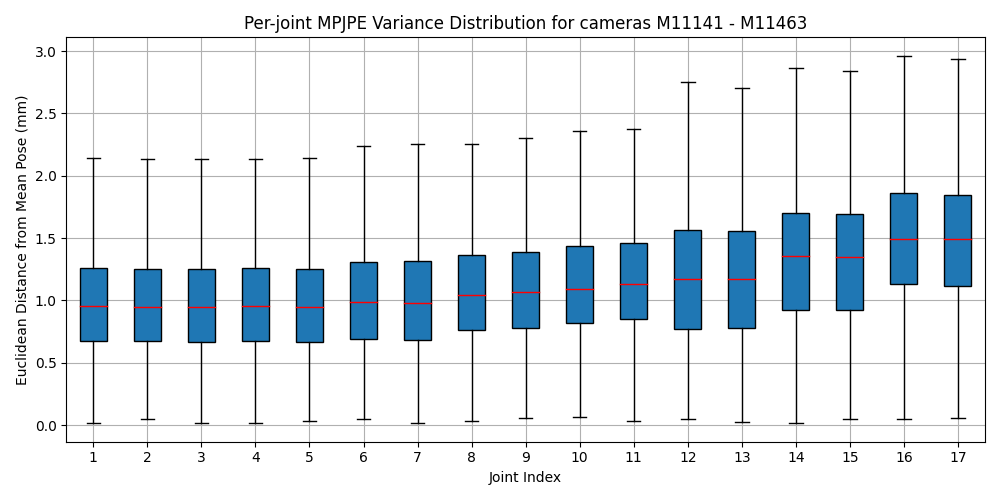

{'N': 192168, 'mean_joint_variance': 1.1550609709879223, 'min_joint_variance': 0.0141101273183008, 'max_joint_variance': 91.50607523111223, 'jointwise_mean': array([0.9977, 0.995 , 0.993 , 0.9995, 0.9906, 1.0319, 1.0246, 1.0934,
       1.1   , 1.147 , 1.174 , 1.1846, 1.1802, 1.3423, 1.3352, 1.5286,
       1.5183]), 'jointwise_median': array([0.9518, 0.9492, 0.9461, 0.9513, 0.9442, 0.9871, 0.9818, 1.0414,
       1.065 , 1.0887, 1.1328, 1.1731, 1.1742, 1.3546, 1.3488, 1.4951,
       1.4945]), 'jointwise_min': array([0.0141, 0.0454, 0.0205, 0.0208, 0.0295, 0.0488, 0.0176, 0.0358,
       0.0603, 0.0629, 0.0347, 0.0475, 0.0227, 0.0157, 0.0471, 0.051 ,
       0.06  ]), 'jointwise_max': array([ 3.5491,  3.5563,  3.4976,  3.7274,  3.6935,  4.0741,  3.7388,
       36.5733,  3.9841,  4.0133, 91.5061,  4.6349,  4.0442,  4.1737,
        4.35  ,  4.5069,  4.8291]), 'jointwise_q1': array([0.6741, 0.6708, 0.6682, 0.6746, 0.6636, 0.6944, 0.6864, 0.7641,
       0.7753, 0.8162, 0.8476, 0.7735, 0.7767, 0

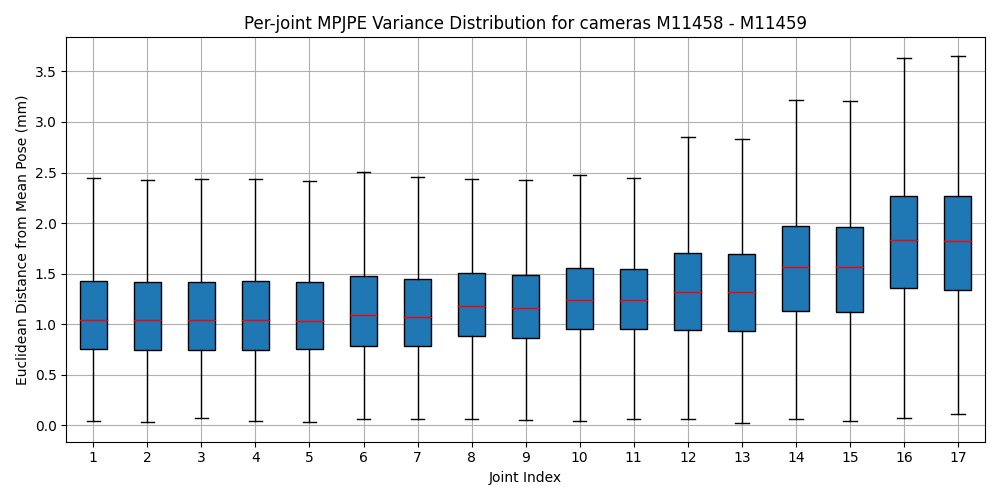

{'N': 130096, 'mean_joint_variance': 1.3681944235616048, 'min_joint_variance': 0.020864879631824707, 'max_joint_variance': 116.03178367133418, 'jointwise_mean': array([1.1687, 1.1646, 1.1643, 1.1756, 1.1705, 1.2271, 1.2078, 1.2902,
       1.2591, 1.3382, 1.316 , 1.4143, 1.4078, 1.6214, 1.6075, 1.8703,
       1.8561]), 'jointwise_median': array([1.0468, 1.0381, 1.04  , 1.0403, 1.0364, 1.0881, 1.0764, 1.176 ,
       1.1621, 1.2414, 1.236 , 1.318 , 1.3165, 1.5678, 1.5674, 1.8311,
       1.8256]), 'jointwise_min': array([0.0443, 0.0353, 0.0701, 0.0411, 0.0343, 0.0632, 0.0651, 0.0601,
       0.0494, 0.0441, 0.0681, 0.061 , 0.0209, 0.0591, 0.045 , 0.0721,
       0.1091]), 'jointwise_max': array([ 10.5779,  10.7102,  10.6759,  11.3249,  11.3551,  11.9259,
        13.7487,  10.0623,  10.5547,   8.832 ,   9.1052,  23.2442,
       116.0318,  22.1573,  19.0256,  17.3827,  22.4807]), 'jointwise_q1': array([0.753 , 0.7474, 0.7475, 0.7493, 0.751 , 0.7898, 0.7804, 0.8806,
       0.8621, 0.9489, 0.951

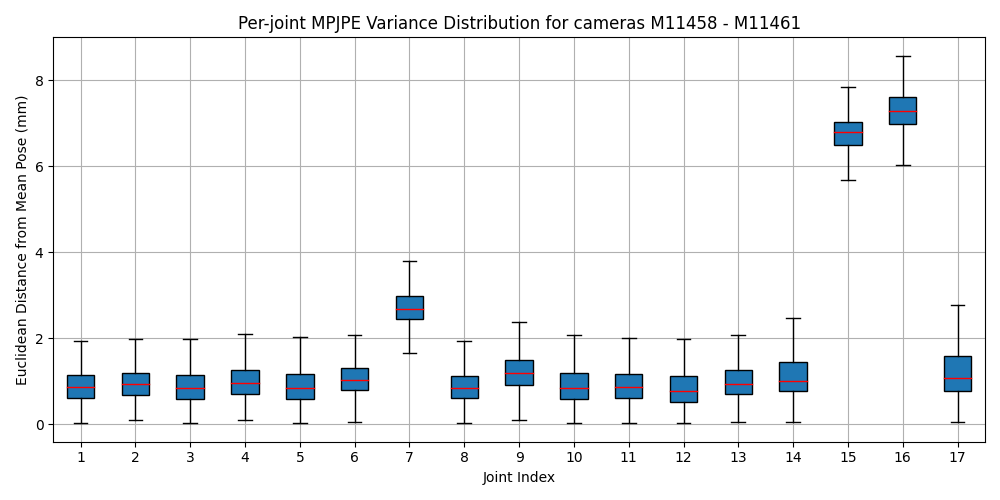

{'N': 147584, 'mean_joint_variance': 4.772118643853955, 'min_joint_variance': 0.02194241946133568, 'max_joint_variance': 112871.02880205988, 'jointwise_mean': array([ 2.0852,  3.4425,  3.4888,  2.2506,  1.9402,  2.6187,  6.4143,
        2.3115,  3.9429,  2.1841,  2.2251,  2.6946,  2.6995,  4.2941,
       14.3629, 17.695 ,  6.4759]), 'jointwise_median': array([0.8677, 0.9306, 0.8445, 0.9516, 0.8541, 1.0308, 2.6806, 0.8405,
       1.1892, 0.847 , 0.8632, 0.7814, 0.9247, 0.9956, 6.7813, 7.285 ,
       1.086 ]), 'jointwise_min': array([0.0243, 0.0936, 0.031 , 0.0964, 0.0219, 0.0407, 0.911 , 0.0246,
       0.1019, 0.0247, 0.0288, 0.0388, 0.0617, 0.0601, 0.9532, 1.0514,
       0.0507]), 'jointwise_max': array([  1804.4084,  15604.3023,  10455.8473,   8231.3552,   2287.3659,
         6617.4832,  44750.0153,   5805.0679,  21942.3709,   2787.5434,
         2152.6385,   2174.193 ,   2753.8913,  16568.8074, 112871.0288,
        72457.5494,  10033.8144]), 'jointwise_q1': array([0.6003, 0.6756, 0.5

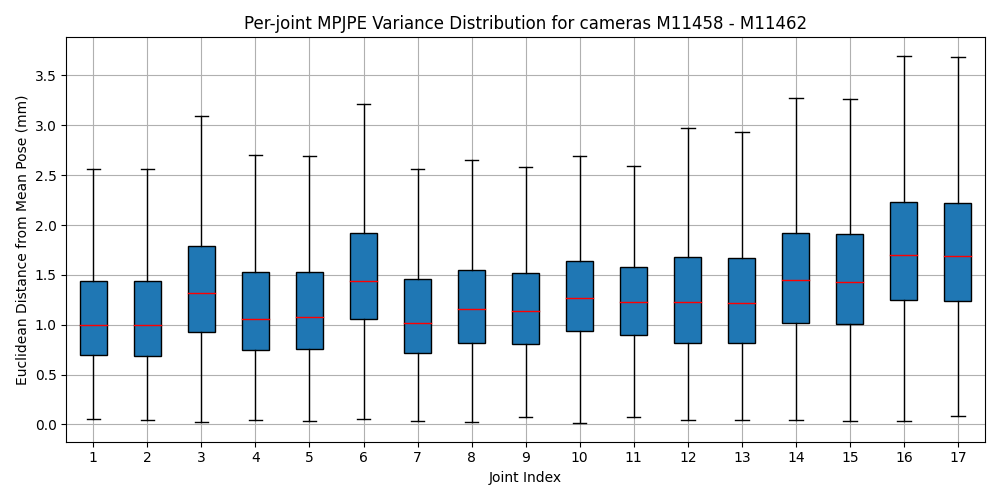

{'N': 196200, 'mean_joint_variance': 1.7399401178406515, 'min_joint_variance': 0.011308150315993174, 'max_joint_variance': 16554.38109790784, 'jointwise_mean': array([1.4545, 1.7738, 2.5309, 1.4917, 1.9021, 2.381 , 1.3528, 1.4423,
       1.3984, 2.1465, 1.4794, 1.5132, 1.4855, 1.6896, 1.6809, 1.93  ,
       1.9266]), 'jointwise_median': array([1.001 , 1.001 , 1.3219, 1.06  , 1.0773, 1.4393, 1.0213, 1.1598,
       1.1363, 1.2681, 1.2298, 1.2247, 1.2214, 1.4499, 1.427 , 1.7033,
       1.685 ]), 'jointwise_min': array([0.0517, 0.0435, 0.0249, 0.0413, 0.0362, 0.0592, 0.0325, 0.0208,
       0.0746, 0.0113, 0.0702, 0.0426, 0.0415, 0.0492, 0.0312, 0.0356,
       0.0803]), 'jointwise_max': array([ 1378.2476,  4261.9053, 16554.3811,   523.2668,  3218.3601,
        3837.3374,   178.2849,   150.6828,    70.5504,  5586.8202,
          88.8993,   137.2145,    75.0157,    66.9167,    44.7441,
          59.8519,    47.9478]), 'jointwise_q1': array([0.6935, 0.6905, 0.9309, 0.7422, 0.7536, 1.0552, 0.71

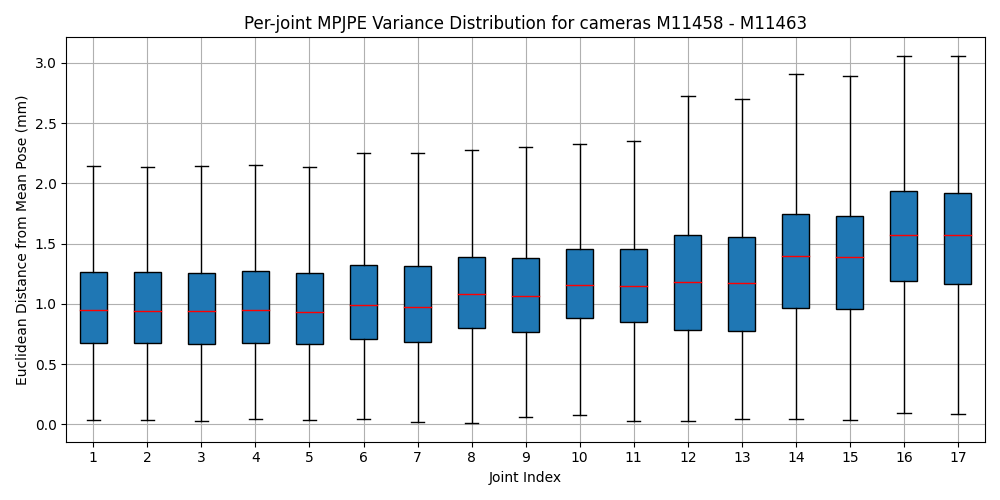

{'N': 141304, 'mean_joint_variance': 1.2044886739583802, 'min_joint_variance': 0.0079063020196699, 'max_joint_variance': 39.638236299846625, 'jointwise_mean': array([1.0374, 1.0364, 1.0305, 1.0427, 1.0238, 1.082 , 1.0516, 1.1614,
       1.123 , 1.2313, 1.2021, 1.2285, 1.2115, 1.4074, 1.3905, 1.6197,
       1.5967]), 'jointwise_median': array([0.9476, 0.944 , 0.9381, 0.9509, 0.9342, 0.9898, 0.9708, 1.0786,
       1.0654, 1.1533, 1.1488, 1.1829, 1.1767, 1.4002, 1.3882, 1.5707,
       1.5672]), 'jointwise_min': array([0.0323, 0.036 , 0.0248, 0.0445, 0.0321, 0.0441, 0.0211, 0.0079,
       0.0642, 0.0794, 0.0303, 0.0251, 0.0403, 0.0434, 0.0325, 0.0446,
       0.0829]), 'jointwise_max': array([19.3506, 20.3412, 19.464 , 21.0992, 17.4584, 20.5452, 18.3794,
       34.0683, 18.6099, 39.6382, 34.6147, 19.7541, 19.1619, 24.8211,
       19.2677, 32.5224, 23.1493]), 'jointwise_q1': array([0.6748, 0.674 , 0.6677, 0.6777, 0.6632, 0.7062, 0.6816, 0.8008,
       0.7668, 0.8786, 0.8522, 0.7823, 0.7734, 

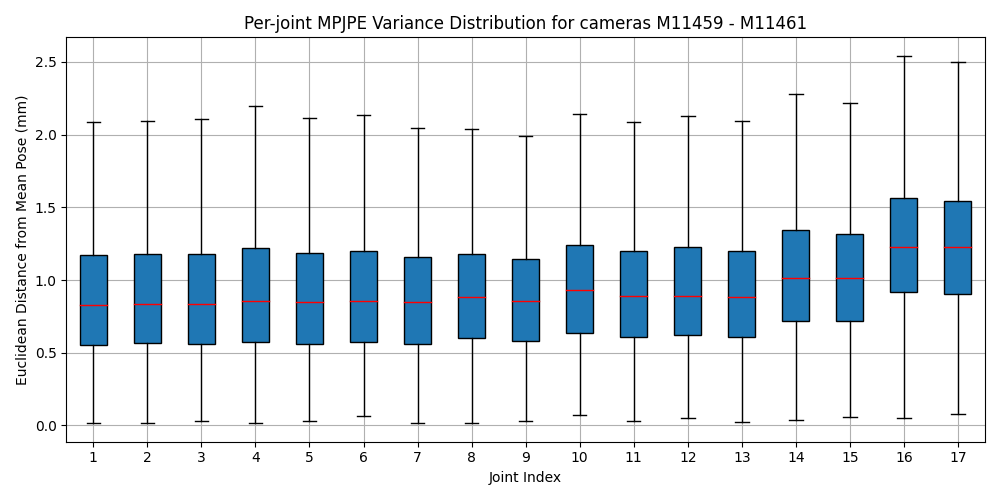

{'N': 78960, 'mean_joint_variance': 1.0735567466953249, 'min_joint_variance': 0.013873276545012053, 'max_joint_variance': 64.4677430369955, 'jointwise_mean': array([0.9651, 0.9754, 0.9684, 1.0014, 0.9815, 1.0196, 0.9864, 1.0393,
       0.9922, 1.0619, 1.0138, 1.0772, 1.0565, 1.1843, 1.1632, 1.3817,
       1.3827]), 'jointwise_median': array([0.8307, 0.8373, 0.8361, 0.8545, 0.8476, 0.8536, 0.8457, 0.8809,
       0.8583, 0.9326, 0.8904, 0.8931, 0.8857, 1.0162, 1.0128, 1.2274,
       1.2278]), 'jointwise_min': array([0.0187, 0.0172, 0.031 , 0.0139, 0.0285, 0.0642, 0.0156, 0.0171,
       0.0282, 0.0733, 0.0317, 0.0509, 0.0241, 0.0379, 0.0581, 0.0472,
       0.0754]), 'jointwise_max': array([ 4.7199,  4.722 ,  4.9799,  4.8169,  4.7077,  5.5491,  4.8556,
        6.088 ,  6.1673,  5.8956,  5.3441,  6.0695,  6.6062,  8.3772,
        5.527 ,  9.4421, 64.4677]), 'jointwise_q1': array([0.5552, 0.5633, 0.5592, 0.5706, 0.5624, 0.5762, 0.5587, 0.6027,
       0.5809, 0.6371, 0.6085, 0.6229, 0.6079, 0

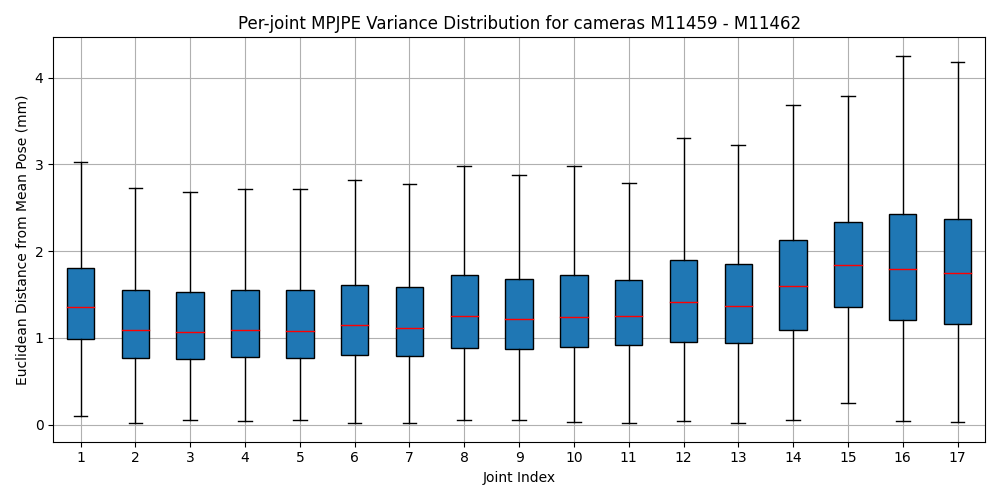

{'N': 139256, 'mean_joint_variance': 2.4465105125021487, 'min_joint_variance': 0.013990463281242755, 'max_joint_variance': 12858.42759402669, 'jointwise_mean': array([2.5534, 2.8004, 1.6673, 1.6474, 1.7821, 2.3239, 1.7532, 2.3981,
       2.1109, 1.8698, 2.8381, 2.5146, 2.2071, 3.0528, 3.4475, 3.4445,
       3.1795]), 'jointwise_median': array([1.3551, 1.0897, 1.0665, 1.0948, 1.0765, 1.1491, 1.1093, 1.2537,
       1.221 , 1.2422, 1.2496, 1.4091, 1.3699, 1.6006, 1.8388, 1.7989,
       1.7501]), 'jointwise_min': array([0.099 , 0.0181, 0.0514, 0.0389, 0.0527, 0.0199, 0.014 , 0.0522,
       0.0531, 0.0325, 0.0196, 0.0451, 0.0208, 0.0481, 0.2435, 0.0436,
       0.0292]), 'jointwise_max': array([ 6189.9929,  9541.4654,  1229.792 ,   329.9011,  2486.4109,
        2433.7552,  1989.1441,  2104.5917,  2031.6815,   574.4754,
        9770.3183,  3067.5972,   788.1571,  4761.8286, 12858.4276,
       10343.84  ,  4093.9734]), 'jointwise_q1': array([0.9838, 0.7686, 0.7571, 0.7783, 0.7651, 0.8019, 0.78

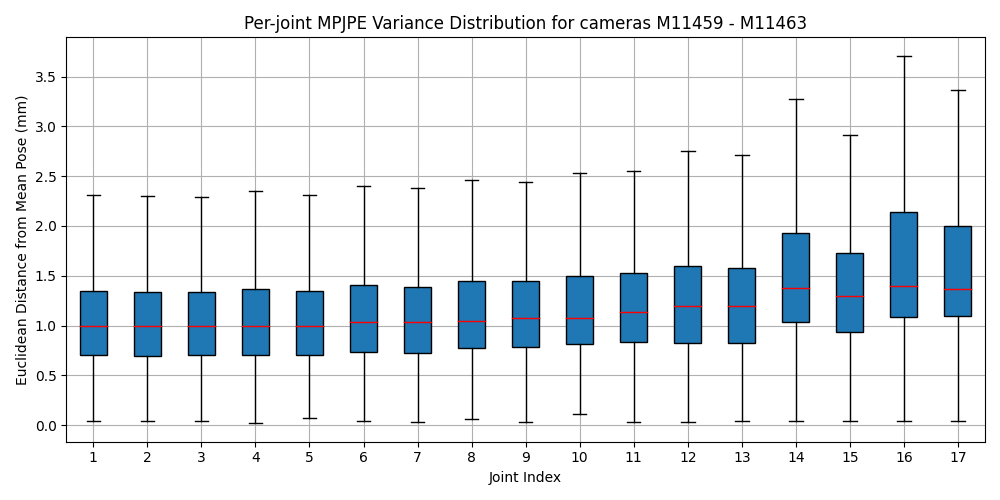

{'N': 112280, 'mean_joint_variance': 1.4968902762011782, 'min_joint_variance': 0.017224912531196464, 'max_joint_variance': 7742.9512023297475, 'jointwise_mean': array([1.0853, 1.0847, 1.0816, 1.1153, 1.0948, 1.3056, 1.1356, 1.4019,
       1.1914, 1.2357, 1.2376, 1.4042, 1.3313, 2.5171, 1.5077, 3.0893,
       2.6277]), 'jointwise_median': array([0.9957, 0.993 , 0.9938, 0.9945, 0.9987, 1.0302, 1.0361, 1.0457,
       1.0791, 1.0761, 1.1341, 1.1926, 1.1982, 1.3816, 1.2952, 1.3923,
       1.3666]), 'jointwise_min': array([0.0437, 0.0435, 0.0406, 0.0172, 0.069 , 0.0438, 0.0345, 0.0654,
       0.0306, 0.1121, 0.0352, 0.0282, 0.0405, 0.036 , 0.0433, 0.0451,
       0.0397]), 'jointwise_max': array([  11.5393,   11.3984,   10.5799,   56.4684,    9.4741,  911.3161,
         10.4723,  539.8083,   11.6465,   56.7071,   19.322 ,  158.805 ,
         35.2064, 7742.9512,   67.6973, 2966.8264, 4056.2577]), 'jointwise_q1': array([0.6994, 0.6981, 0.6988, 0.7005, 0.6997, 0.7301, 0.7222, 0.7735,
       0.78

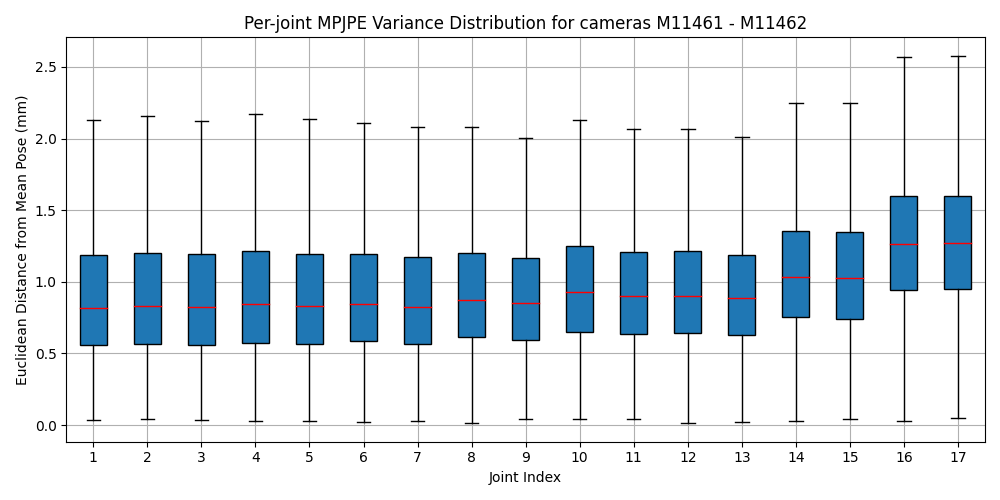

{'N': 149888, 'mean_joint_variance': 1.1302987738463093, 'min_joint_variance': 0.011812110448344801, 'max_joint_variance': 427.13464330386324, 'jointwise_mean': array([1.0155, 1.0238, 1.0212, 1.0418, 1.0339, 1.0556, 1.0416, 1.0774,
       1.0701, 1.1137, 1.1014, 1.1181, 1.1121, 1.2388, 1.2315, 1.4586,
       1.4602]), 'jointwise_median': array([0.8195, 0.8285, 0.8231, 0.842 , 0.831 , 0.8436, 0.8226, 0.8699,
       0.8485, 0.9275, 0.8979, 0.8988, 0.888 , 1.0354, 1.0248, 1.2622,
       1.2705]), 'jointwise_min': array([0.0352, 0.0436, 0.0339, 0.026 , 0.03  , 0.0205, 0.0309, 0.0118,
       0.0404, 0.0421, 0.0387, 0.0155, 0.022 , 0.0287, 0.045 , 0.0313,
       0.0518]), 'jointwise_max': array([  6.394 ,   6.3549,   8.2925,   6.235 ,   6.4643,   8.232 ,
         9.0773,   7.641 ,  11.1483,  12.8291,  11.829 ,   7.6382,
        10.665 ,  35.2773,  25.8699, 427.1346, 406.6892]), 'jointwise_q1': array([0.5593, 0.5647, 0.5605, 0.5757, 0.5665, 0.5869, 0.5662, 0.6154,
       0.5965, 0.6506, 0.636

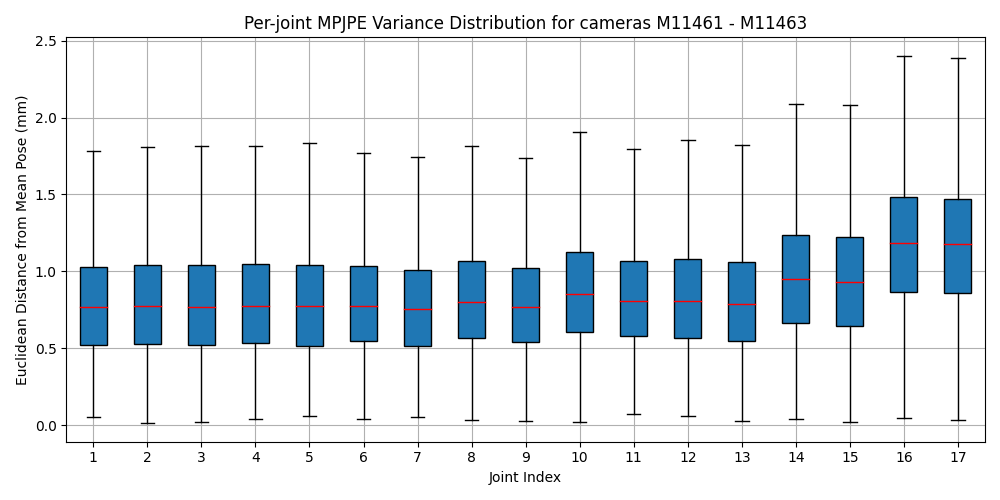

{'N': 78160, 'mean_joint_variance': 0.9302975692438935, 'min_joint_variance': 0.011744018445798235, 'max_joint_variance': 807.7268905234331, 'jointwise_mean': array([0.8302, 0.9427, 0.8439, 0.8504, 0.925 , 0.8495, 0.8525, 0.8736,
       0.8419, 0.9153, 0.8798, 0.8864, 0.8788, 1.011 , 0.9987, 1.2224,
       1.213 ]), 'jointwise_median': array([0.7656, 0.7766, 0.771 , 0.7762, 0.7743, 0.7732, 0.7578, 0.8035,
       0.7659, 0.8541, 0.8047, 0.8046, 0.7861, 0.948 , 0.9331, 1.1831,
       1.1755]), 'jointwise_min': array([0.0509, 0.0117, 0.0217, 0.0411, 0.0584, 0.039 , 0.0516, 0.0331,
       0.0287, 0.022 , 0.0697, 0.0615, 0.0301, 0.039 , 0.0202, 0.0481,
       0.0341]), 'jointwise_max': array([ 47.6904, 807.7269,  76.2195,  37.0098, 562.7426,  12.0012,
        92.8956,   6.0341,   5.9669,   4.92  ,   9.0312,  26.4606,
        46.3498,  18.9816,  29.2309,  17.2652,  26.9808]), 'jointwise_q1': array([0.5227, 0.5276, 0.5207, 0.536 , 0.5177, 0.5453, 0.5172, 0.5638,
       0.5388, 0.6081, 0.5788,

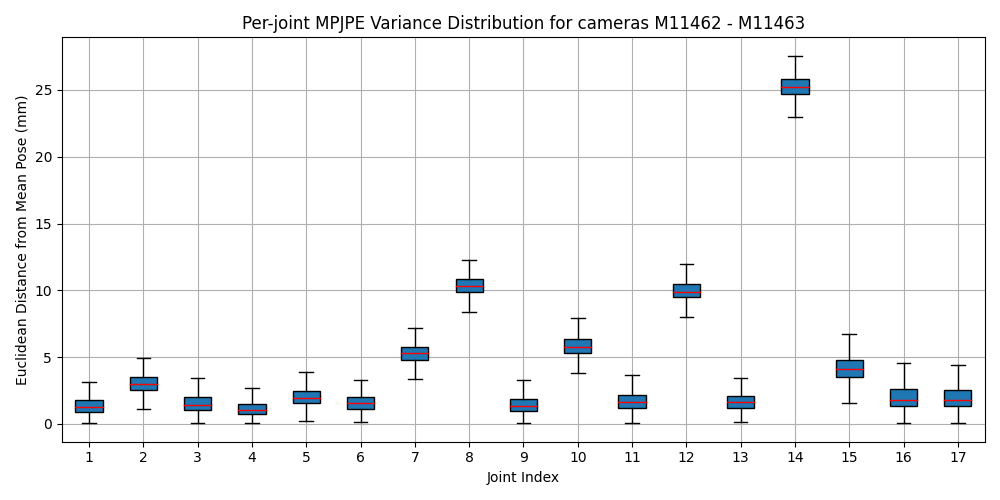

{'N': 166464, 'mean_joint_variance': 20.879893848360524, 'min_joint_variance': 0.03607806922032901, 'max_joint_variance': 511652.19771652494, 'jointwise_mean': array([17.7086, 21.7841, 14.448 , 15.1163, 13.9839, 14.8367, 20.816 ,
       36.65  , 11.9119, 54.3205,  9.6464, 26.1599,  9.1322, 54.8583,
       16.9686,  7.3587,  9.2581]), 'jointwise_median': array([ 1.2765,  2.9776,  1.4324,  1.0521,  1.9705,  1.5417,  5.2715,
       10.3394,  1.3444,  5.7824,  1.6055,  9.9026,  1.641 , 25.2453,
        4.0754,  1.7979,  1.7957]), 'jointwise_min': array([0.0361, 0.1516, 0.0435, 0.0365, 0.2326, 0.1133, 0.2089, 0.6824,
       0.0567, 0.9811, 0.0813, 2.3723, 0.1204, 0.6073, 0.2319, 0.0842,
       0.0587]), 'jointwise_max': array([ 55138.7461,  77644.4986,  12289.5414,  23011.4598,  10293.6237,
        30226.7736,  77893.5618, 103951.2843,  23577.5104, 422214.2811,
        18894.3314, 218940.6391,  15198.0111, 511652.1977, 113599.3117,
         7386.2921,  25085.1709]), 'jointwise_q1': array([ 

In [ ]:

def compute_mpjpe_variance(keypoints_list, c, plot=True):
    """
    Computes MPJPE-like statistics and plots joint variance distribution.
    
    Parameters:
        keypoints_list (List[np.ndarray]): list of arrays of shape (num_joints, 3)
        plot (bool): whether to generate a plot of per-joint statistics
    
    Returns:
        mean_joint_variance (float)
        jointwise_mean (np.ndarray)
        jointwise_median (np.ndarray)
        jointwise_min (np.ndarray)
        jointwise_max (np.ndarray)
    """
    keypoints_array = np.stack(keypoints_list)  # shape: (N, J, 3)
    mean_pose = np.mean(keypoints_array, axis=0)  # shape: (J, 3)
    
    # Euclidean distance from mean pose, shape: (N, J)
    errors = np.linalg.norm(keypoints_array - mean_pose, axis=2)  # (N, J)
    N = errors.shape[0]

    # Aggregate statistics
    mean_joint_variance = np.mean(errors)
    min_joint_variance = np.min(errors)
    max_joint_variance = np.max(errors)

    jointwise_mean = np.mean(errors, axis=0)     # shape: (J,)
    jointwise_median = np.median(errors, axis=0) # shape: (J,)
    jointwise_min = np.min(errors, axis=0)       # shape: (J,)
    jointwise_max = np.max(errors, axis=0)       # shape: (J,)
    jointwise_q1 = np.percentile(errors, 25, axis=0)
    jointwise_q3 = np.percentile(errors, 75, axis=0)
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.boxplot(errors, showfliers=False, patch_artist=True, medianprops={'color': 'red'})
        plt.title(f"Per-joint MPJPE Variance Distribution for cameras {cameras[int(c[0])]} - {cameras[int(c[-1])]}")
        plt.xlabel("Joint Index")
        plt.ylabel("Euclidean Distance from Mean Pose (mm)")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f'MPJPE_var_{cameras[int(c[0])]} - {cameras[int(c[-1])]}')
        plt.show()
    
    return {
        'N': N,
        'mean_joint_variance': mean_joint_variance,
        'min_joint_variance': min_joint_variance,
        'max_joint_variance': max_joint_variance,
        'jointwise_mean': jointwise_mean,
        'jointwise_median': jointwise_median,
        'jointwise_min': jointwise_min,
        'jointwise_max': jointwise_max,
        'jointwise_q1': jointwise_q1,
        'jointwise_q3': jointwise_q3}, errors


with open('/home/lea/vitpose/triangulated_points.pkl', 'rb') as f:
    triangulated_points = pickle.load(f)

errors_all, stats_all = [], []
for c, keypoints_list in triangulated_points.items():
    
    print(f'{cameras[int(c[0])]} - {cameras[int(c[-1])]}')
    stats, errors = compute_mpjpe_variance(keypoints_list, c, plot=True)
    print(stats)

    stats_all.append((c, stats))
    errors_all.append(errors)

    """ print(f'Mean joint variance: {mean_error:.2f} mm')
    print(f'Min joint variance: {min_error:.2f} mm')
    print(f'Max joint variance: {max_error:.2f} mm')
    print(f'Per-joint variance: {per_joint_error} \n') """

In [ ]:
N_all, mean_all, joint_mean_all = 0, 0, 0

for c, stats in stats_all:
    N = stats['N']
    mean = stats['mean_joint_variance']
    jointwise_mean = stats['jointwise_mean']
    jointwise_median = stats['jointwise_median']

    N_all += N
    mean_all += N*mean
    joint_mean_all += N*jointwise_mean

mean_all /= N_all
joint_mean_all /= N_all

print(f'Mean: {mean_all:.2f}')
print(f'Jointwise mean: {joint_mean_all}')


Mean: 2.43
Jointwise mean: [2.0505 2.3874 1.9787 1.9392 1.9465 2.1756 2.2671 2.8618 1.9818 3.589
 1.8509 2.5553 1.8227 3.8795 2.7481 2.7498 2.452 ]


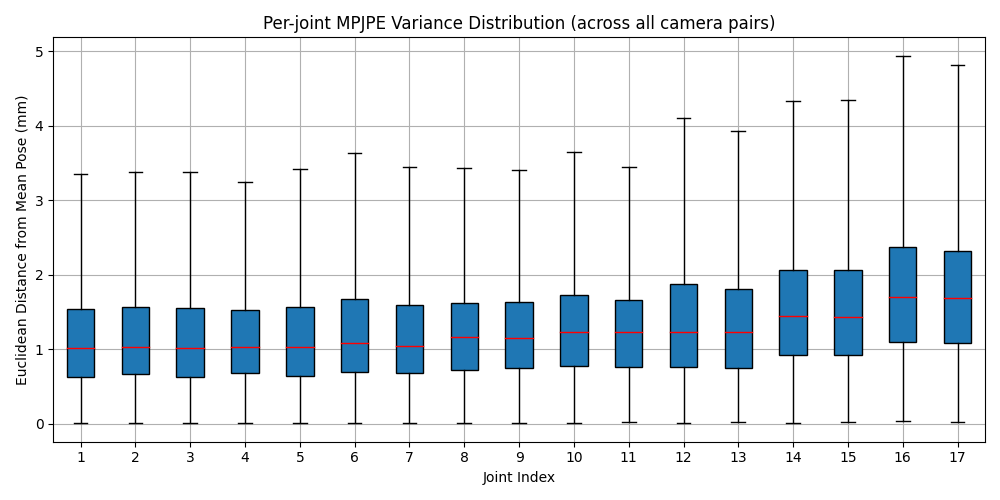

In [ ]:
# Assume you have collected these per joint, each shape: (17,)
meds = np.percentile([stats['jointwise_median'] for _, stats in stats_all], 50, axis=0)
q1s = np.percentile([stats['jointwise_q1'] for _, stats in stats_all], 25, axis=0)
q3s = np.percentile([stats['jointwise_q3'] for _, stats in stats_all], 75, axis=0)
iqrs = q3s - q1s

# Mimic matplotlib default whiskers
whisker_min = q1s - 2 * iqrs
whisker_max = q3s + 2 * iqrs

# Clip within real min/max
true_mins = np.min([stats['jointwise_min'] for _, stats in stats_all], axis=0)
true_maxs = np.max([stats['jointwise_max'] for _, stats in stats_all], axis=0)

whisker_min = np.maximum(whisker_min, true_mins)
whisker_max = np.minimum(whisker_max, true_maxs)

# Build the boxplot-compatible stats list
boxplot_data = []
for i in range(len(meds)):
    boxplot_data.append({
        'med': meds[i],
        'q1': q1s[i],
        'q3': q3s[i],
        'whislo': whisker_min[i],  # min
        'whishi': whisker_max[i],  # max
        'fliers': []        # no outliers
    })

# Plot it
fig, ax = plt.subplots(figsize=(10, 5))
ax.bxp(boxplot_data, showfliers=False, patch_artist=True,
       boxprops=dict(facecolor='#1f77b4', alpha=1),
       medianprops={'color': 'red'})

ax.set_title("Per-joint MPJPE Variance Distribution (across all camera pairs)")
ax.set_xlabel("Joint Index")
ax.set_ylabel("Euclidean Distance from Mean Pose (mm)")
ax.set_xticks(np.arange(1, len(meds)+1))  # 1 to 17
ax.grid(True)
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


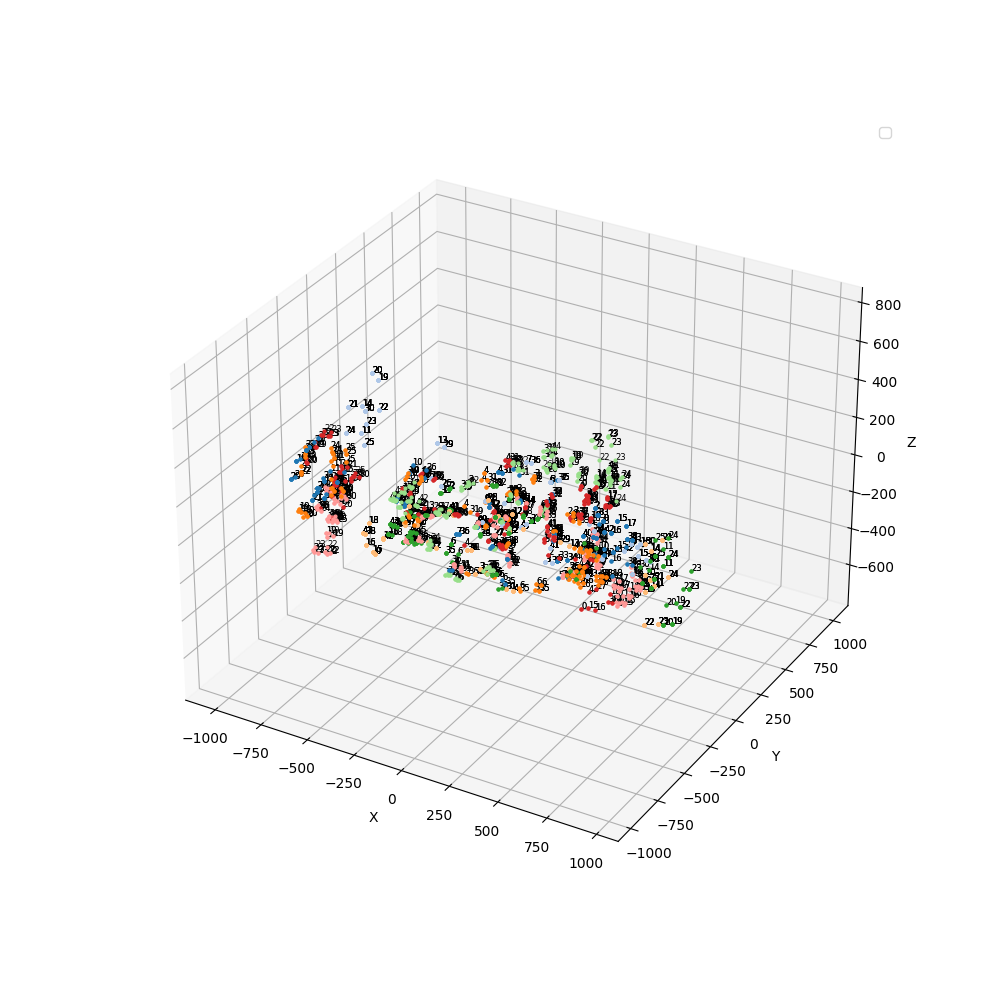

{'61-62': [698.9946318682305], '39-41': [172.35836674793543], '58-63': [950.7763453185531], '39-40': [339.605367893984], '39-62': [138.68137498716925], '41-59': [944.632583956141], '40-61': [770.7940298895867], '40-63': [305.49743009587525], '41-58': [943.6818665629662], '59-61': [691.4014583199108], '41-63': [254.81325862313466], '58-62': [955.966603648392], '59-63': [958.5984694831093], '61-63': [774.4145806382129], '40-58': [939.6329456360951], '40-59': [932.1311792238661], '59-62': [949.9187183741034], '39-59': [930.6074275528065], '58-59': [216.20715205832224], '39-63': [321.5518725920766], '62-63': [146.40591307372114], '39-58': [939.708342052715], '39-61': [729.1800907754846], '58-61': [713.4561578073051], '41-61': [676.6760863446826], '40-62': [328.4352547487299], '40-41': [372.5918818482708], '41-62': [226.02009478785004]}
Outliers par paire de caméras :
39-40: 1 accepted, mean = 339.605367893984
39-41: 1 accepted, mean = 172.35836674793543
39-58: 1 accepted, mean = 939.708342

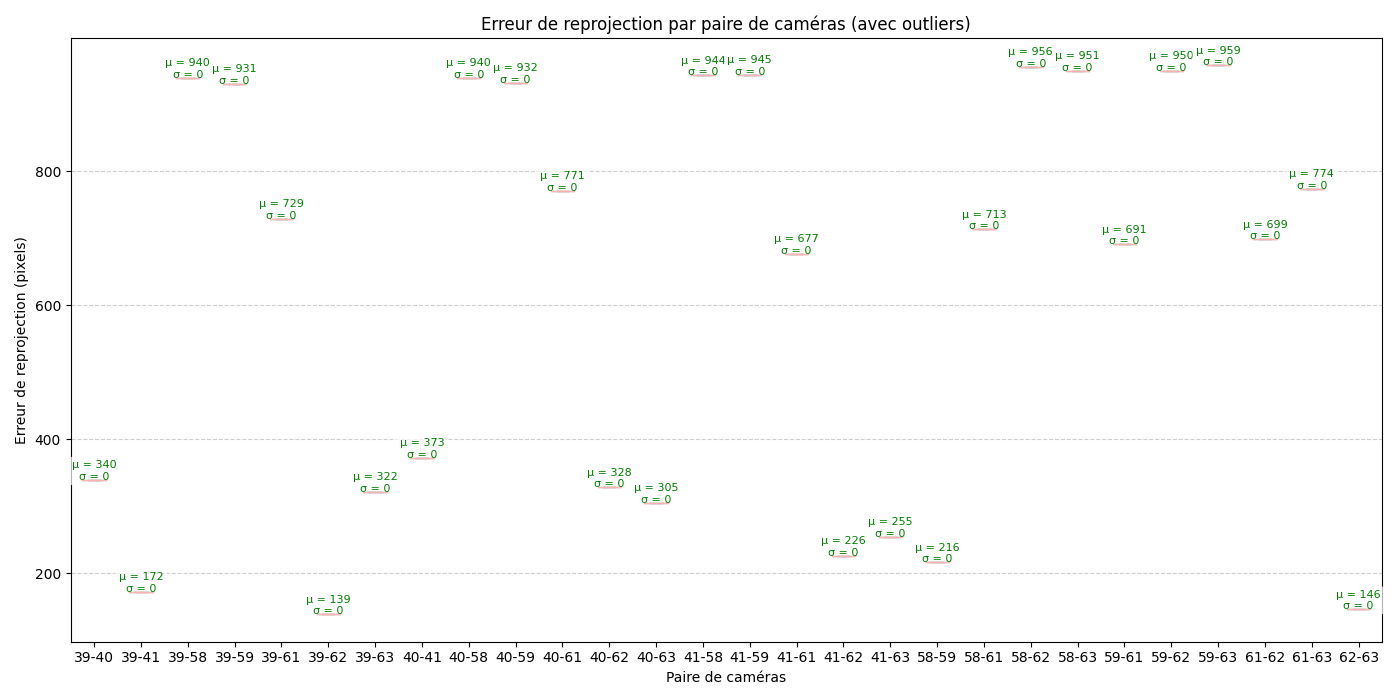

In [ ]:

%matplotlib widget
plt.close()

cmap = plt.colormaps.get_cmap('tab20')
colors = [cmap(i / 20) for i in range(17)]

def transform_points(pts3d, T):
    pts3d_h = np.hstack((pts3d, np.ones((pts3d.shape[0], 1)))).T
    pts4d = (T @ pts3d_h).T
    pts3d_t = pts4d[:, :3] / pts4d[:, 3].reshape(-1, 1)
    return pts3d_t

def reproject(keypoints_detections, cameras, N_images):
    error_cam_1 = {f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras}

    error_cam = [{f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras} for _ in range(8)]

    T = np.load('/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Calib_trampo_avril2025/results_calib/calib_0429/WorldTCam_opt.npz')['arr_0']

    # Create 3D plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')

    R = np.array([[0,1,0], [0,0,1], [1,0,0]])

    for c1 in range(8):
        T1 = T[c1]
        for c2 in range(c1+1, 8):
            T2 = T[c2]
            for frame_idx in range(N_images):
                try:
                    pts3d_1 = np.asarray(keypoints_detections[frame_idx][cameras[c1]])[0, :, :]
                    pts3d_2 = np.asarray(keypoints_detections[frame_idx][cameras[c2]])[0, :, :]
                except KeyError:
                    continue

                #TODO: ajouter filtre pour vérifier qu'il s'agit de la même personne (en remplacement de [0, :, :] ci-haut)

                #pts3d_1 = (1000 * (R @ pts3d_1.T)).T # convert to mm
                #pts3d_2 = (1000 * (R @ pts3d_2.T)).T # convert to mm
                pts3d_1 *= 1000
                pts3d_2 *= 1000

                #print('Original points')
                #print(pts3d_1)
                
                draw_keypoints(pts3d_1, colors, ax, c1, 4, 6)
                draw_keypoints(pts3d_2, colors, ax, c2, 4, 6)
                #draw_skeleton(pts3d_1, colors[c1], ax, 'original', 45)
                #draw_skeleton(pts3d_2, colors[c2], ax, 'original', 45)

                # FORMULA: 1T2 = inv(T1) @ T2

                """ pts3d_3 = transform_points(pts3d_2, T1)
                pts3d_4 = transform_points(pts3d_2, T2)
                pts3d_5 = transform_points(pts3d_2, np.linalg.inv(T1))
                pts3d_6 = transform_points(pts3d_2, np.linalg.inv(T2))

                #draw_keypoints(pts3d_2_1, colors, ax, 10)
                draw_skeleton(pts3d_3, colors[c1+2], ax, f'{c1} T1')
                draw_skeleton(pts3d_4, colors[c1+3], ax, f'{c1} T2')
                draw_skeleton(pts3d_5, colors[c1+4], ax, f'{c1} inv(T1)')
                draw_skeleton(pts3d_6, colors[c1+5], ax, f'{c1} inv(T2)') """

                #print('Reprojected points')
                #print(pts3d_2_1)

                error1 = np.linalg.norm(pts3d_1 - pts3d_2, axis=1)
                #error2 = np.linalg.norm(pts3d_2 - pts3d_1_2, axis=1)
                error_cam_1[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error1))
                #error_cam_2[f'{cameras[c1][-2:]}-{cameras[c2][-2:]}'].append(np.mean(error2))

                break
            #break
        #break
        
    ax.axis('equal')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.show()

    error_cam_1_filtered = {k: v for k, v in error_cam_1.items() if len(v) > 0}
    #error_cam_2_filtered = {k: v for k, v in error_cam_2.items() if len(v) > 0}

    return error_cam_1_filtered #, error_cam_2_filtered, error_cam

video_path = '/mnt/D494C4CF94C4B4F0/Trampoline_avril2025/Images_trampo_avril2025/20250429/'
root_path = '/home/lea/trampo/metrics/SMPL_keypoints'

cameras = ['M11139', 'M11140', 'M11141', 'M11458', 'M11459', 'M11461', 'M11462', 'M11463']
routines = sorted([os.path.basename(f).split('-')[0] for f in os.listdir(root_path)])[:3]

error_cam_all = {}
#error_cam_per_view_all = [{f'{c1[-2:]}-{c2[-2:]}':[] for c1 in cameras for c2 in cameras} for _ in range(8)]

routine = routines[0]

paths = [routine+'-Camera1_M11139.pkl', routine+'-Camera2_M11140.pkl', routine+'-Camera3_M11141.pkl', routine+'-Camera4_M11458.pkl',
         routine+'-Camera5_M11459.pkl', routine+'-Camera6_M11461.pkl', routine+'-Camera7_M11462.pkl', routine+'-Camera8_M11463.pkl',]

if all_views_processed(root_path, paths, routine):
    N_images = len(os.listdir(video_path+routine+'-Camera1_M11139'))
    keypts_cam = retrieve_keypts(root_path, paths)

    id_per_frame_per_cam = retrieve_common_id(keypts_cam)
    keypts_per_cam = select_keypoints_athlete(keypts_cam, id_per_frame_per_cam)
    keypoints_detections = create_dict_all_detections(keypts_cam, N_images, cameras, id_per_frame_per_cam, '3d')

    error_cam_1 = reproject(keypoints_detections, cameras, N_images)

    all_keys = set(error_cam_1) | set(error_cam_all)

    error_cam_all = {k: error_cam_1.get(k, [])+ error_cam_all.get(k, []) for k in all_keys}

    #for i, el in enumerate(error_cam_per_view):
    #    error_cam_per_view_all[i] = {k: error_cam_per_view_all[i].get(k, []) + el.get(k, []) for k in all_keys}

print(error_cam_all)
plot_view_consistency(error_cam_all, remove_outliers=False)



Outliers par paire de caméras :
39-40: 89928 accepted, mean = 4.562704794292209
39-40: 18456 outlier(s), mean = 178.9995716331371
39-41: 94440 accepted, mean = 190.98240145145988
39-41: 14280 outlier(s), mean = 12659.637848119139
39-58: 93816 accepted, mean = 6.669773778961766
39-58: 14184 outlier(s), mean = 283.2984287817327
39-59: 102456 accepted, mean = 4.7530296192157575
39-59: 6264 outlier(s), mean = 28.056486536068782
39-61: 92376 accepted, mean = 15.075428420349674
39-61: 12120 outlier(s), mean = 139.27006969877218
39-62: 99072 accepted, mean = 2.370777968200237
39-62: 9648 outlier(s), mean = 43.273220667392344
39-63: 101544 accepted, mean = 6.044913644604033
39-63: 7176 outlier(s), mean = 140.64430207241645
40-41: 101088 accepted, mean = 71.53978547652397
40-41: 7296 outlier(s), mean = 2058.8498633097392
40-58: 99240 accepted, mean = 5.086983027071638
40-58: 8760 outlier(s), mean = 292.2151805483791
40-59: 92568 accepted, mean = 5.459759919565954
40-59: 15816 outlier(s), mean =

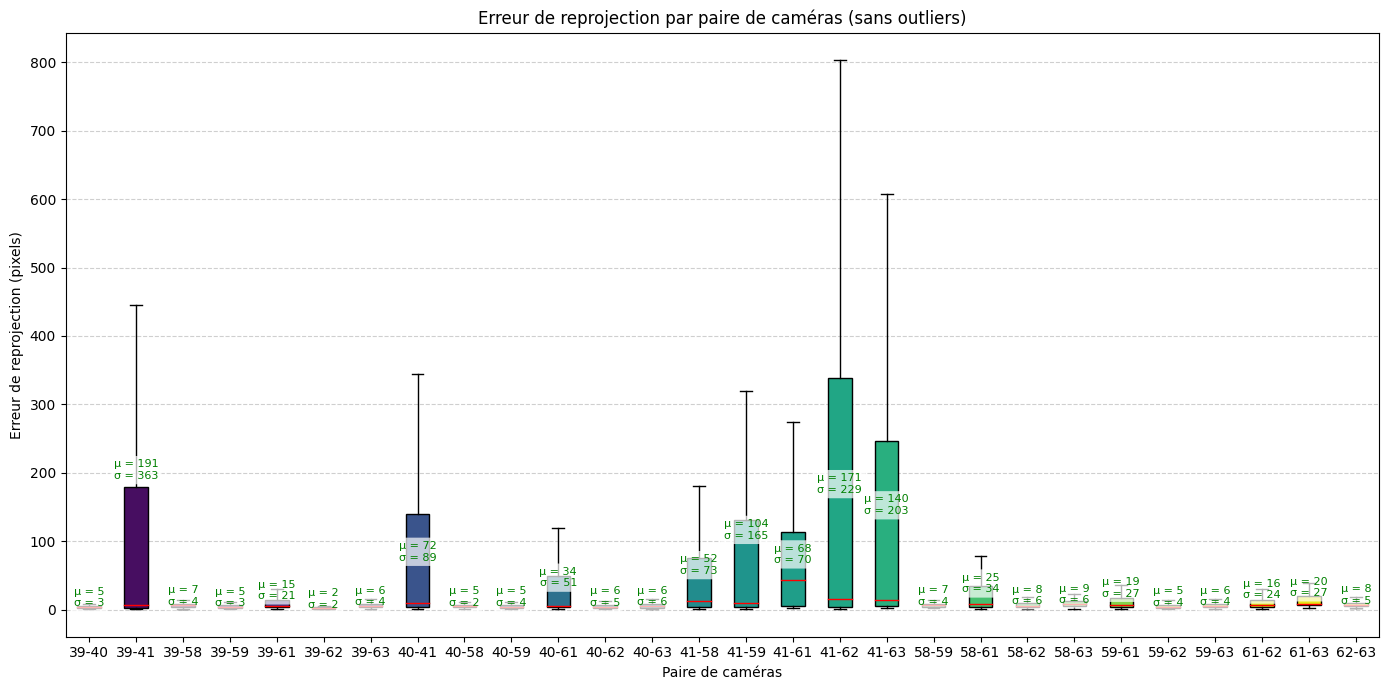

In [40]:
with open('/home/lea/trampo/metrics/error_4dhumans_filt.json', 'r') as f:
    error_cam_all = json.load(f)

plot_view_consistency(error_cam_all, no_outliers=True)